# Exploring Gephi Graph Streaming
Sources of information and inspiration:

[Gephi - Graph Streaming](https://github.com/gephi/gephi/wiki/GraphStreaming)

[Visualization of Large Dynamic Networks](http://www.eecs.wsu.edu/~yyao/DynamicGraph.html)


## Versions of software, packages, and libraries used:
- Python 3.6
- Jupyter Notebook 5.4.1
- Gephi 0.92
- requests 2.18.4
- numpy 1.14.2
- NetworkX 2.1
- Matplotlib 2.2.2

Notes:
- [NetworkX: Migration guide from 1.X to 2.0](https://networkx.github.io/documentation/stable/release/migration_guide_from_1.x_to_2.0.html)

# Setup and Foundation

## Gephi Graph Streaming plugin

The Gephi Graph Streaming plugin must be installed. To do this, start Gephi and open the Plugins page (Tools -> Plugins). Switch to the Available Plugins panel, find and select Graph Streaming in the list and click Install. Once complete Gephi may need to restart to enable the plugin.

## Turning on Gephi Master (Streaming)

- Run the Gephi application
- Create an empty workspace (File -> New Project, or Workspace -> New)
- Add some nodes and edges to your graph
- Go to the Streaming tab (next to Appearance in the lower left)
- right-click on the “Master Server” and select “Start”

## Start a Graph Stream

You can obtain a stream of graph events by making a `getGraph` request to Gephi. 

`curl "http://localhost:8080/workspace1?operation=getGraph"`

This will not terminate, it is a live stream of Graph events that will run "forever" (that is, until Gephi Streaming is turned off, Gephi terminates, or the client requesting the stream is stopped).

Note: this is not a required step to run this Notebook, nor is it necessary to use the Gephi Graph Streaming API. It is simply an example, and an effective means to observe a Gephi Graph Stream. 

## Gephi API
Below is a simple implementation of the Gephi Graph Streaming API based on [`GephiJsonClient`](http://www.eecs.wsu.edu/~yyao/DirectedStudyII/src/Citation/GephiJsonClient.py); it is modified for newer version of Python and newer version of Gephi. Also it was changed to use the [`requests`](http://docs.python-requests.org/en/master/) library, which also has the benefit of simplifying the implementation significantly.

### Parameters
**Where is Gephi running?**
- `host` = the name of the machine where Gephi is running
- `port` = the HTTP port for the Gephi REST API
- `workspace` = number of the Gephi workspace

In [220]:
host = "localhost"
port = 8080
workspace = 1

### Build a URL from the parameters
This URL provides access to manipulate the graph in Gephi, note the `operation=updateGraph`. There are other operations which allow querying Gephi for vertex and edge information, and probably others which were not explored in this project.

Each *workspace* in Gephi is a separate space and must be addresed directly; note the `/workspace` part of the URL with a trailing number. Gephi *Graph Streaming* must be turned on for each workspace that we want to acccess.

In [221]:
def gephiURL(host, port, workspace):
    return "http://{}:{}/workspace{}?operation=updateGraph".format(host, port, workspace)

In [222]:
url = gephiURL(host, port, workspace)
print(url)

http://localhost:8080/workspace1?operation=updateGraph


### JSON formatted messages

A JSON document with the specific graph operation is POST'ed to the above URL:
- Vertex operations:
    - `an`: add node
    - `cn`: update node
    - `dn`: delete node
- Edge operations:
    - `ae`: add edge
    - `ce`: update edge
    - `de`: delete edge

Example: *Add Node*
```
{
  "an":{
        "A":{
             "label":"Node A",
             "size":2
            }
  }
}
```

Example: *Add Edge*
```
{
  "ae":{
        "AB":{
              "source":"A",
              "target":"B",
              "directed":false,
              "weight":2
             }
  }
}
```

### Gephi direct access functions

In [223]:
import requests

def post(content):
    #print(content)
    response = requests.post(url, json=content)
    return response

In [224]:
def addVertex(node, attr={}):
    content = {"an":{""+node:attr}}
    return post(content)

def removeVertex(node):
    content = {"dn":{""+node:{}}}
    return post(content)

def changeVertex(node, attr={}):
    content = {"cn":{""+node:attr}}
    return post(content)

def addEdge(eid, source, target, directed=False, weight=1.0):
    attributes = {}
    attributes['source'] = source;
    attributes['target'] = target;
    attributes['directed'] = directed;
    attributes['weight'] = weight
    content = {'ae': {eid:attributes}}
    return post(content)

def removeEdge(eid):
    content = {'de':{eid:{}}}
    return post(content)

def changeEdge(eid, attr={}):
    content = {'ce':{eid:attr}}
    return post(content)

### Gephi convenience functions

In [225]:
def addNode(node):
    return addVertex(str(node), {'label':str(node)})

def addLink(source, target, directed=False, weight=1.0):
    return addEdge("{}-{}".format(str(source), str(target)), str(source), str(target), directed, weight)

def addLinks(links):
    for link in links:
        addLink(link[0], link[1])

def connect(node, neighbors):
    '''
    connect(node, neighbors)
      connect a node to list of neighbors

      Inputs:
        node = the source node
        neighbors = a list of target neighbors
    '''
    for neighbor in neighbors:
        addLink(node, neighbor)

def newNode(node, neighbors):
    '''
    newNode(node, neighbors)
      Create a node node and connect to a list of neighbors

      Inputs:
        node = the new node to be added
        neighbors = a list of neighbors
    '''
    addNode(node)
    connect(node, neighbors)

def deleteNode(node):
    removeVertex(str(node))

BLACK = '#000000'
WHITE = '#ffffff'
RED   = '#ff0000'
GREEN = '#00ff00'
BLUE  = '#0000ff'

def setNodeColor(node, color):
    node = str(node)
    attr = {'color':color}
    return changeVertex(node, attr)

DEFAULT = 10.0
SMALL   = 5.0
MEDIUM  = 15.0
LARGE   = 25.0
XLARGE  = 50.0

def setNodeSize(node, size):
    node = str(node)
    attr = {'size':size}
    return changeVertex(node, attr)


### Create a graph in Gephi

#### custom format -> Gephi

This custom format is a multi-level Python dictionary. The top-level keys represent the vertices of the graph. The values are dictionaries which designate directed edges where the keys are the target vertices and the values are the weights.

In [226]:
graph = {
    's': {'a': 2, 'b': 1},
    'a': {'s': 3, 'b': 4, 'c': 8},
    'b': {'s': 4, 'a': 2, 'd': 2},
    'c': {'a': 2, 'd': 7, 't': 4},
    'd': {'b': 1, 'c': 11, 't': 5},
    't': {'c': 3, 'd': 5}
}

In [227]:
'''
gephiGraphCuston(graph)
  Create a graph in Gephi from custom graph format
  
  Inputs:
    graph = graph in custom format
    
  Notes:
    Creates an undirected and unweighted graph, despite the fact 
    that the custom format allows specifying directed and weighted.
'''
def gephiGraphCuston(graph):
    for node in graph:
        response = addNode(node)
    for node in graph:
        for neighbor in graph[node]:
            response = addLink(node, neighbor)

#### NetworkX -> Gephi
This takes a NetworkX `Graph` and will send a series of commands (for all of the nodes and links) to construct and visualize the graph in Gephi.

In [228]:
'''
gephiGraphNx(graph)
  Create a graph in Gephi from a NetworkX graph
  
  Inputs:
    graph = a NetworkX graph
    
  Notes:
    Creates an undirected and unweighted graph.
'''
def gephiGraphNx(graph):
    for node in graph.nodes():
        result = addNode(str(node))
    for edge in graph.edges():
        source = edge[0]
        target = edge[1]
        result = addLink(str(source), str(target))

## Network Creation functions

In [229]:
import numpy as np
import networkx as nx

'''
barabasi_albert_graph(n, m=1):
    a function that takes `n` the number of nodes for the graph, 
    and `m` the initial number of nodes, as arguments and returns a networkx 
    graph with a scale-free degree distribution.
'''
def barabasi_albert_graph_without_using_degree(n, m=1):
    # create a complete graph with m initial nodes. 
    # (note: we could use nx.complete_graph() here, but opt to do the creation manually
    # to keep the `type` of the graph created as Graph instead of Complete Graph)
    g = nx.Graph()
    for i in range(m):
        g.add_node(i)
        for j in range(i+1,m):
            g.add_edge(i,j)
    
    # while network has less than n nodes, 
    for i in range(m, n):
        # get the list of edges
        edges = [e for e in g.edges]
        # randomly select m of the edges with equal probability
        selected = np.random.choice(len(edges), m, replace=False)
        # create a new node
        g.add_node(i)
        for s in selected:
            # for each of the selected edges, randomly pick one of the nodes
            linkTo = np.random.choice(edges[s], 1)[0]
            # and add an edge from the new node to that node
            g.add_edge(i, linkTo)
    
    return g

## Plotting and Supporting funtions

### Graph Calculations

In [230]:
import networkx as nx

def averageDegree(graph):
    return sum([x[1] for x in list(nx.degree(graph))])/len(nx.nodes(graph))

In [231]:
def probabilityForDegree(N, k):
    return k/(N-1)

In [232]:
import networkx as nx

def graphDegreeTopN(graph, n=10):
    nodes = sorted(list(nx.degree(graph)), key=lambda x: x[1], reverse=True)
    print("{0:4s} {1:8s} {2:8s}".format("N","Node","Degree"))
    print("---- -------- --------")
    for i in range(n):
        print("{0:4d} {1:8d} {2:8d}".format(i+1,nodes[i][0],nodes[i][1]))

### Plot Degree Distribution

In [233]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def showDegreeDistribution(graph):
    degrees = sorted([d[1] for d in graph.degree()])
    (v, e, p) = plt.hist(degrees)
    
def showDegreeDistributionWithFit(graph):
    degrees = sorted([d[1] for d in graph.degree()])
    (y, x, p) = plt.hist(degrees)
    y = np.append(y, [0])
    z = np.polyfit(x, y, 3)
    f = np.poly1d(z)
    x_new = np.linspace(x[0], x[-1], 50)
    y_new = f(x_new)
    plt.plot(x_new, y_new, "r")
    plt.xlim([x[0]-1, x[-1] + 1 ])
    plt.show()
    
def showDegreeDistributionLogScale(graph):
    degrees = sorted([d[1] for d in graph.degree()], reverse=True)
    x = np.arange(0, len(degrees))
    plt.plot(x, degrees, "r")
    plt.xscale('log')
    plt.show()
    
def showDegreeDistributionLogLogScale(graph):
    degrees = sorted([d[1] for d in graph.degree()], reverse=True)
    x = np.arange(0, len(degrees))
    plt.loglog(x, degrees, "r")
    plt.show()

# Method

## Overview
The exploration is essentailly these steps: create a graph, run a simulation which performs a spreading process. The exploration will be run on static graphs where this is no dynamic behavior: no nodes or edges are added or removed. This will act as a baseline from which we can compare the results on dynamic graphs.

The exploration will be performed on:
- static graphs: no dynamic graph activity, just a spreading process
- dynamic graphs: spreading with an addative process
- dynamic graphs: spreading with an addative and random detractive process
- dynamic graphs: spreading with an addative and targeted detractive process
- dynamic graphs: spreading with an addative and more invasive targetted detractive process
- dynamic graphs: spreading with a larger addative and extreme invasive targetted detractive process

## Discussion
- what will be the starting point?
- probably a BA graph (Power Law degree distribution)
- what is the normal dynamic nature?
- adding vertices, and edges
- at what rate?
- how will we control time?
- what are the different fault models?
  - what are the targets? (vertices or edges)
  - failure: random target selected
  - attack: specific target selected
- how are the fault models controlled?
- what is the measure for robustness?
- how will we show the robustness measure?

Ultimately I would like to define, model, and run the simulation from the Jupyter Nodebook. The activity should be visible in the Jupyter Notebook (i.e., printing messages about actions taking place), observe the live activity in Gephi, and at periodic intervals export data which can be displayed in Cubix (separately, after the simulation completes).

## Implementation

### Simulation Driver

In [234]:
import time

def simulate(graph, model, max_iterations = 100):
    spreader = model.spreader()
    grower = model.grower()
    destroyer = model.destroyer()
    
    def init():
        return {'spread':      {'count': {interval: 0}, 'total': {interval: 0}},
                'growth':      {'count': {interval: 0}, 'total': {interval: 0}},
                'destruction': {'count': {interval: 0}, 'total': {interval: 0}}}
    
    def track(tracking, key, count):
        if interval > 0:
            total = tracking[key]['total'][interval-1]
        else:
            total = 0
        tracking[key]['count'][interval] = count
        tracking[key]['total'][interval] = (total + count)
        return

    def spreadingProcess():
        spread = spreader.spread(graph)
        track(tracking, 'spread', spread)
        return spread

    def growingProcess():
        growth = grower.grow(graph)
        track(tracking, 'growth', growth)
        return growth

    def destroyingProcess():
        destruction = destroyer.destroy(graph)
        track(tracking, 'destruction', destruction)
        return destruction

    # start...
    interval = 0
    tracking = init()
    # initial contact to a single 'origin' node
    spread = spreader.spread(graph)
    track(tracking, 'spread', spread)
    # pause a little so we can observe the 'origin' selection
    time.sleep(10)
    
    # run until spreading stops, or the max number of iterations has elapsed
    while (spread != 0) and (interval < max_iterations):
        interval += 1
        # Step 1: run growing
        if grower != None: growth = growingProcess()
        # Step 2: run destruction
        if destroyer != None: destruction = destroyingProcess()
        # Step 3: run spreading
        spread = spreadingProcess()
        # pause so we can observe each iteration's activity
        time.sleep(2)

    return tracking

### Spreading Process

In [235]:
import networkx as nx

class Spreader:
    contagion='infected'
    indicator=RED
    interval = 0
    
    def __init__(self, contagion='infected', indicator=RED):
        self.contagion = contagion
        self.indicator = indicator

    def config(self):
        print("Spreader() contagion: {} indicator: {}".format(self.contagion, self.indicator))
        
    def infect(self, graph, node, size=DEFAULT):
        graph.nodes[node].update({self.contagion: True})
        setNodeColor(node, self.indicator)
        setNodeSize(node, size)

    def initial(self, graph):
        # add the contagion attribute to all nodes
        nx.set_node_attributes(graph, name=self.contagion, values=False)
        # randomly select the origin
        origin = np.random.choice(list(graph.nodes()), 1)[0]
        self.infect(graph, origin, size=LARGE)
        return 1
    
    def incremental(self, graph, infected):
        self.interval += 1
        count = 0
        # infect any uninfected neighbors of the infected nodes
        for node in infected:
            for neighbor in nx.neighbors(graph, node):
                if not graph.nodes.data()[neighbor][self.contagion]:
                    print("time: {0:4d} spread from: {1} -> {2}".format(self.interval, node, neighbor))
                    self.infect(graph, neighbor)
                    count += 1
        return count
    
    def uninitialized(self, graph):
        nodes = [node[0] for node in filter(lambda x: x[1] == None, list(graph.nodes(data=self.contagion)))]
        for node in nodes:
            graph.nodes[node].update({self.contagion: False})
    
    def spread(self, graph):
        infected = [node[0] for node in filter(lambda x: x[1] == True, list(graph.nodes(data=self.contagion)))]
        if len(infected) == 0:
            return self.initial(graph)
        else:
            self.uninitialized(graph)
            return self.incremental(graph, infected)

### Graph trait for additive and detractive processes

In [236]:
class Grapher:
    def __init__(self):
        pass
    
    def graphAdd(self, graph, node, edges, color=BLACK, size=DEFAULT):
        self.graphAddNode(graph, node, color, size)
        self.graphAddEdges(graph, edges)
    
    def graphAddNode(self, graph, node, color=BLACK, size=DEFAULT):
        # add node to NetworkX graph
        graph.add_node(node)
        # add node to Gephi, and set color
        addNode(node)
        setNodeColor(node, color)

    def graphAddEdge(self, graph, source, target):
        # add edge to NetworkX graph
        graph.add_edge(source, target)
        # add edge to Gephi
        addLink(source, target)
    
    def graphAddEdges(self, graph, edges):
        # add edges to NetworkX graph
        graph.add_edges_from(edges)
        # add edges to Gephi
        addLinks(edges)
        
    def graphDeleteNode(self, graph, node):
        # delete node from NetworkX graph
        graph.remove_node(node)
        # delete node in Gephi
        deleteNode(node)

### Additive Process

In [237]:
import numpy as np

class Expander(Grapher):
    interval = 0
    nodes = 0
    links = 0
    next_node = 0
    
    def __init__(self, nodes = 10, links = 10):
        self.nodes = nodes
        self.links = links

    def expand(self, graph):
        self.interval += 0
        nodes = list(graph.nodes())
        if self.next_node == 0:
            self.next_node = max(nodes)
        for i in range(self.nodes + 1):
            self.next_node += 1
            neighbors = np.random.choice(nodes, self.links, replace=False)
            edges = list(zip(np.full(len(neighbors), self.next_node), neighbors))
            self.graphAdd(graph, self.next_node, edges, color=BLUE)
        return self.nodes

class HubCreator(Grapher):
    interval = 0
    number = 3
    threshold = 0.25

    def __init__(self, number = 3, threshold = 0.25):
        self.number = number
        self.threshold = threshold
        
    def create(self, graph):
        self.interval += 0
        created = 0
        # find top `number` of nodes by degree
        # count how many have degree >= threshold?
        # if `count` is less than `number`
        # then create `number` - `count` hubs with degree (`threshold` * graph.number_of_nodes)
        return created
    
class Grower:
    interval = 0
    expander = None
    hubCreator = None
    
    def __init__(self, expander = None, hubCreator = None):
        self.expander = expander
        self.hubCreator = hubCreator

    def grow(self, graph):
        self.interval += 1
        growth = 0
        if self.expander != None: 
            growth += self.expander.expand(graph)
        if self.hubCreator != None:
            growth += self.hubCreator.create(graph)
        return growth

### Detractive Process

In [238]:
import numpy as np

class Target:
    number = 10
    percent = 0.0
    
    def __init__(self, number=10, percent=0.0):
        self.number = number
        self.percent = percent

class TargetRandomNodes(Target):
    def select(self, graph):
        nodes = list(graph.nodes())
        # randomly select a percent of all nodes, or a fixed number of nodes
        if self.percent > 0.0:
            targets = np.random.choice(nodes, int(self.percent * len(nodes)), replace=False)
        else:
            targets = np.random.choice(nodes, self.number, replace=False)
        return targets

class TargetHighDegreeNodes(Target):
    def select(self, graph):
        # get list of nodes ordered by degree, descending (highest -> lowest)
        nodes = [y[0] for y in sorted(list(nx.degree(graph)), key=lambda x: x[1], reverse=True)]
        # select targetted nodes, starting from the head of the list
        if self.percent > 0.0:
            target = nodes[0:int(self.percent * len(nodes))]
        else:
            target = nodes[0:self.number]
        return target
    
class Destroyer(Grapher):
    interval = 0
    target = None
    
    def __init__(self, target=None):
        self.target = target

    def destroy(self, graph):
        self.interval += 1
        count = 0
        if self.target != None:
            selected = self.target.select(graph)
            for node in selected:
                count += 1
                self.graphDeleteNode(graph, node)
        return count

### Model

In [239]:
'''
Model

  Contains the three components of the dynamic model
  - Spreader: responsible for the spreading process
  - Grower: responsibile for dynamically growing the graph
  - Destroyer: destroys elements of the graph

'''
class Model:
    _spreader = None
    _grower = None
    _destroyer = None

    def spreader(self):
        return self._spreader
    
    def grower(self):
        return self._grower
    
    def destroyer(self):
        return self._destroyer

In [240]:
'''
SpreadingOnly

  Provides only a Spreader.
  
'''
class SpreadingOnly(Model):
    def __init__(self, graph = None):
        self._spreader = Spreader()
        self._grower = None
        self._destroyer = None

In [241]:
'''
AdditiveOnly

  Provides a Spreader, and a Grower with an Expander that will add nodes based
  on the `nodes` parameter, and links based on the `links` parameter or the 
  average degree of the graph.
  
'''
class AdditiveOnly(Model):
    def __init__(self, graph, nodes=20, links=-1):
        if links == -1:
            links = round(averageDegree(graph))
        self._spreader = Spreader()
        self._grower = Grower(expander = Expander(nodes = nodes, 
                                                  links = links), 
                              hubCreator = None)
        self._destroyer = None

In [242]:
'''
AddativeWithFixedRandomDetractive

  Provides a Spreader, and a Grower with an Expander, and also provides a 
  Destroyer that will TargetRandomNodes on a fixed number basis defined 
  by the `remove` parameter.
  
'''
class AddativeWithFixedRandomDetractive(Model):
    def __init__(self, graph, nodes=20, links=-1, remove=20):
        if links == -1:
            links = round(averageDegree(graph))
        self._spreader = Spreader()
        self._grower = Grower(expander = Expander(nodes = nodes, 
                                                  links = links), 
                              hubCreator = None)
        self._destroyer = Destroyer(target=TargetRandomNodes(number = remove, percent = 0.0))

In [243]:
'''
AddativeWithPercentRandomDetractive

  Provides a Spreader, and a Grower with an Expander, and also provides a 
  Destroyer that will TargetRandomNodes on a top-n percentage basis defined 
  by the `percent` parameter.
  
'''
class AddativeWithPercentRandomDetractive(Model):
    def __init__(self, graph, nodes=20, links=-1, percent=0.05):
        if links == -1:
            links = round(averageDegree(graph))
        self._spreader = Spreader()
        self._grower = Grower(expander = Expander(nodes = nodes, 
                                                  links = links), 
                              hubCreator = None)
        self._destroyer = Destroyer(target=TargetRandomNodes(number = 0, percent = percent))

In [244]:
'''
AddativeWithTargetedDetractive

  Provides a Spreader, and a Grower with an Expander, and a Destroyer that will
  TargetHighDegreeNodes by number specified by the `remove` parameter..

'''
class AddativeWithTargetedDetractive(Model):
    def __init__(self, graph, nodes=20, links=-1, remove=1):
        if links == -1:
            links = round(averageDegree(graph))
        self._spreader = Spreader()
        self._grower = Grower(expander = Expander(nodes = nodes, 
                                                  links = links), 
                              hubCreator = None)
        self._destroyer = Destroyer(target=TargetHighDegreeNodes(number = remove, percent = 0.0))

In [245]:
'''
AddativeWithInvasiveDetractive

  Provides a Spreader, and a Grower with an Expander, and a Destroyer that will
  TargetRandomNodes on a top-n percent basis.
   
'''
class AddativeWithInvasiveDetractive(Model):
    def __init__(self, graph, nodes=20, links=-1, percent=0.025):
        if links == -1:
            links = round(averageDegree(graph))
        self._spreader = Spreader()
        self._grower = Grower(expander = Expander(nodes = nodes, 
                                                  links = links), 
                              hubCreator = None)
        self._destroyer = Destroyer(target=TargetHighDegreeNodes(number = 0, percent = percent))

In [246]:
'''
AddativeWithExtremeInvasiveDetractive

  Provides a Spreader, and a Grower with an Expander that has a higher node additive value, 
  and a Destroyer that will TargetRandomNodes with a high top-n percent value.
   
'''
class AddativeWithExtremeInvasiveDetractive(Model):
    def __init__(self, graph, nodes=50, links=-1, percent=0.10):
        if links == -1:
            links = round(averageDegree(graph))
        self._spreader = Spreader()
        self._grower = Grower(expander = Expander(nodes = nodes, 
                                                  links = links), 
                              hubCreator = None)
        self._destroyer = Destroyer(target=TargetHighDegreeNodes(number = 0, percent = percent))

### Results Processing

In [247]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

class Results:
    results = {}
    data = {}
    
    def __init__(self):
        pass
    
    def store(self, tag, results):
        self.results[tag] = results
        self.data[tag] = self.resultsDataFrame(results)
    
    def showResultsTable(self, tag):
        return self.data[tag]
    
    def showSpreading(self, tag):
        results = self.results[tag]
        x = list(results['spread']['count'].keys())
        y1 = list(results['spread']['count'].values())
        y2 = list(results['spread']['total'].values())
        plt.plot(x, y1, "r--", label='spread')
        plt.plot(x, y2, "b", label='infected')
        plt.xlabel('time')
        plt.ylabel('count')
        plt.legend()
        plt.show()
        
    def resultsDataFrame(self, results):
        df = pd.DataFrame(columns=['time',
                                   'spread_count', 'spread_total',
                                   'growth_count', 'growth_total',
                                   'destruction_count', 'destruction_total'])
        times = list(results['spread']['count'].keys())
        df.time = times
        if len(list(results['spread']['count'].values())) == len(times):
            df.spread_count = list(results['spread']['count'].values())
            df.spread_total = list(results['spread']['total'].values())
        if len(list(results['growth']['count'].values())) == len(times):
            df.growth_count = list(results['growth']['count'].values())
            df.growth_total = list(results['growth']['total'].values())
        if len(list(results['destruction']['count'].values())) == len(times):
            df.destruction_count = list(results['destruction']['count'].values())
            df.destruction_total = list(results['destruction']['total'].values())
        return df

### Graph Creation

In [248]:
# Erdos-Renyi graph model
class ErdosRenyiGraph:
    N = 500
    p = 0.01

In [249]:
import networkx as nx

def randomGraph():
    return nx.erdos_renyi_graph(ErdosRenyiGraph.N, ErdosRenyiGraph.p)

In [250]:
# Barabasi-Albert graph model
class BarabasiAlbertGraph:
    N = 500
    m_o = 7

In [251]:
def baGraph():
    return barabasi_albert_graph_without_using_degree(BarabasiAlbertGraph.N, BarabasiAlbertGraph.m_o)

### Simulation Parameters and Run-time

In [252]:
class Simulation:
    max_iterations = 10

In [253]:
results = Results()

# Exploration

## Static Graphs - spreading process only

### Erdos-Renyi (random) graph

In [485]:
url = gephiURL(host, port, 1)
tag = "static-er-spreading-only"

In [486]:
graph1 = randomGraph()

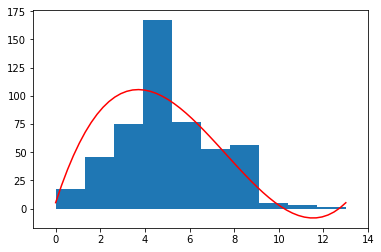

In [487]:
showDegreeDistributionWithFit(graph1)

In [488]:
%%time
gephiGraphNx(graph1)

CPU times: user 4.03 s, sys: 585 ms, total: 4.62 s
Wall time: 5.65 s


In [489]:
averageDegree(graph1)

4.984

In [490]:
results.store(tag, simulate(graph1, SpreadingOnly(), Simulation.max_iterations))

time:    1 spread from: 13 -> 41
time:    1 spread from: 13 -> 104
time:    1 spread from: 13 -> 255
time:    1 spread from: 13 -> 386
time:    1 spread from: 13 -> 442
time:    1 spread from: 13 -> 470
time:    2 spread from: 41 -> 407
time:    2 spread from: 41 -> 421
time:    2 spread from: 104 -> 103
time:    2 spread from: 104 -> 131
time:    2 spread from: 104 -> 183
time:    2 spread from: 104 -> 222
time:    2 spread from: 104 -> 456
time:    2 spread from: 104 -> 489
time:    2 spread from: 255 -> 66
time:    2 spread from: 255 -> 238
time:    2 spread from: 255 -> 266
time:    2 spread from: 255 -> 412
time:    2 spread from: 255 -> 479
time:    2 spread from: 386 -> 50
time:    2 spread from: 386 -> 161
time:    2 spread from: 386 -> 209
time:    2 spread from: 386 -> 220
time:    2 spread from: 386 -> 332
time:    2 spread from: 386 -> 405
time:    2 spread from: 386 -> 415
time:    2 spread from: 442 -> 250
time:    2 spread from: 442 -> 400
time:    2 spread from: 442 -> 

time:    4 spread from: 110 -> 85
time:    4 spread from: 110 -> 146
time:    4 spread from: 110 -> 368
time:    4 spread from: 114 -> 423
time:    4 spread from: 115 -> 109
time:    4 spread from: 115 -> 192
time:    4 spread from: 115 -> 232
time:    4 spread from: 115 -> 331
time:    4 spread from: 117 -> 19
time:    4 spread from: 117 -> 119
time:    4 spread from: 117 -> 357
time:    4 spread from: 117 -> 403
time:    4 spread from: 118 -> 210
time:    4 spread from: 118 -> 245
time:    4 spread from: 118 -> 323
time:    4 spread from: 137 -> 270
time:    4 spread from: 137 -> 377
time:    4 spread from: 139 -> 240
time:    4 spread from: 139 -> 263
time:    4 spread from: 139 -> 358
time:    4 spread from: 143 -> 59
time:    4 spread from: 152 -> 113
time:    4 spread from: 152 -> 204
time:    4 spread from: 152 -> 207
time:    4 spread from: 152 -> 310
time:    4 spread from: 153 -> 289
time:    4 spread from: 154 -> 32
time:    4 spread from: 154 -> 87
time:    4 spread from: 1

time:    5 spread from: 438 -> 141
time:    5 spread from: 482 -> 301
time:    5 spread from: 484 -> 187
time:    6 spread from: 141 -> 435
time:    6 spread from: 208 -> 72
time:    6 spread from: 259 -> 107
time:    6 spread from: 275 -> 228


In [491]:
results.showResultsTable(tag)

,time,spread_count,spread_total,growth_count,growth_total,destruction_count,destruction_total
0,0,1,1,NaN,NaN,NaN,NaN
1,1,6,7,NaN,NaN,NaN,NaN
2,2,33,40,NaN,NaN,NaN,NaN
3,3,122,162,NaN,NaN,NaN,NaN
4,4,234,396,NaN,NaN,NaN,NaN
5,5,98,494,NaN,NaN,NaN,NaN
6,6,4,498,NaN,NaN,NaN,NaN
7,7,0,498,NaN,NaN,NaN,NaN


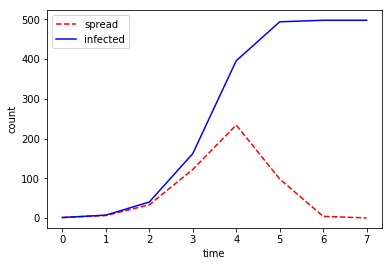

In [492]:
results.showSpreading(tag)

### Barabasi-Albert graph

In [493]:
url = gephiURL(host, port, 2)
tag = "static-ba-spreading-only"

In [494]:
graph2 = baGraph()

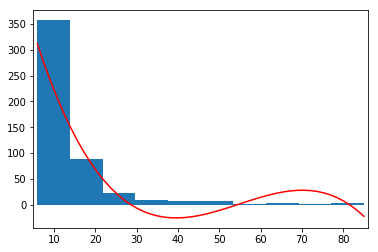

In [495]:
showDegreeDistributionWithFit(graph2)

In [496]:
%%time
gephiGraphNx(graph2)

CPU times: user 8.61 s, sys: 1.2 s, total: 9.81 s
Wall time: 12.1 s


In [497]:
averageDegree(graph2)

13.528

In [498]:
graphDegreeTopN(graph2)

N    Node     Degree  
---- -------- --------
   1        0       85
   2        2       80
   3       10       80
   4        6       75
   5        1       73
   6       15       69
   7        4       65
   8        7       64
   9       14       56
  10        8       55


In [499]:
results.store(tag, simulate(graph2, SpreadingOnly(), Simulation.max_iterations))

time:    1 spread from: 263 -> 47
time:    1 spread from: 263 -> 117
time:    1 spread from: 263 -> 17
time:    1 spread from: 263 -> 2
time:    1 spread from: 263 -> 246
time:    1 spread from: 263 -> 7
time:    1 spread from: 263 -> 76
time:    1 spread from: 263 -> 399
time:    1 spread from: 263 -> 440
time:    1 spread from: 263 -> 492
time:    1 spread from: 263 -> 494
time:    2 spread from: 2 -> 0
time:    2 spread from: 2 -> 1
time:    2 spread from: 2 -> 3
time:    2 spread from: 2 -> 4
time:    2 spread from: 2 -> 5
time:    2 spread from: 2 -> 6
time:    2 spread from: 2 -> 8
time:    2 spread from: 2 -> 13
time:    2 spread from: 2 -> 15
time:    2 spread from: 2 -> 16
time:    2 spread from: 2 -> 18
time:    2 spread from: 2 -> 21
time:    2 spread from: 2 -> 25
time:    2 spread from: 2 -> 28
time:    2 spread from: 2 -> 37
time:    2 spread from: 2 -> 40
time:    2 spread from: 2 -> 42
time:    2 spread from: 2 -> 43
time:    2 spread from: 2 -> 48
time:    2 spread fro

time:    3 spread from: 1 -> 353
time:    3 spread from: 1 -> 355
time:    3 spread from: 1 -> 358
time:    3 spread from: 1 -> 372
time:    3 spread from: 1 -> 374
time:    3 spread from: 1 -> 380
time:    3 spread from: 1 -> 381
time:    3 spread from: 1 -> 490
time:    3 spread from: 3 -> 29
time:    3 spread from: 3 -> 52
time:    3 spread from: 3 -> 103
time:    3 spread from: 3 -> 108
time:    3 spread from: 3 -> 148
time:    3 spread from: 3 -> 167
time:    3 spread from: 3 -> 207
time:    3 spread from: 3 -> 211
time:    3 spread from: 3 -> 216
time:    3 spread from: 3 -> 274
time:    3 spread from: 3 -> 308
time:    3 spread from: 3 -> 335
time:    3 spread from: 3 -> 360
time:    3 spread from: 3 -> 361
time:    3 spread from: 3 -> 373
time:    3 spread from: 3 -> 409
time:    3 spread from: 3 -> 425
time:    3 spread from: 3 -> 444
time:    3 spread from: 3 -> 449
time:    3 spread from: 3 -> 472
time:    3 spread from: 4 -> 23
time:    3 spread from: 4 -> 88
time:    3 spr

In [500]:
results.showResultsTable(tag)

,time,spread_count,spread_total,growth_count,growth_total,destruction_count,destruction_total
0,0,1,1,NaN,NaN,NaN,NaN
1,1,11,12,NaN,NaN,NaN,NaN
2,2,203,215,NaN,NaN,NaN,NaN
3,3,285,500,NaN,NaN,NaN,NaN
4,4,0,500,NaN,NaN,NaN,NaN


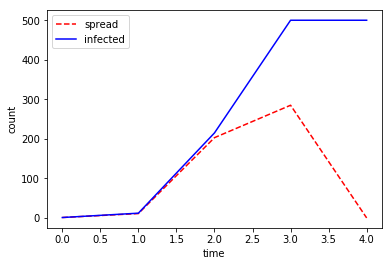

In [501]:
results.showSpreading(tag)

## Dynamic Graphs - spreading with additive process

### Erdos-Renyi (random) graph

In [502]:
url = gephiURL(host, port, 3)
tag = "dynamic-er-additive-only"

In [503]:
graph3 = randomGraph()

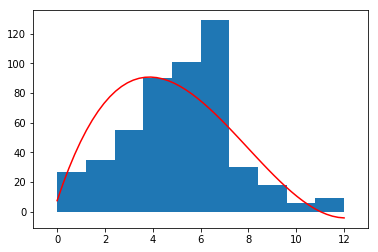

In [504]:
showDegreeDistributionWithFit(graph3)

In [505]:
%%time
gephiGraphNx(graph3)

CPU times: user 4.06 s, sys: 568 ms, total: 4.63 s
Wall time: 5.71 s


In [506]:
averageDegree(graph3)

5.012

In [507]:
results.store(tag, simulate(graph3, AdditiveOnly(graph3), Simulation.max_iterations))

time:    1 spread from: 160 -> 53
time:    1 spread from: 160 -> 113
time:    1 spread from: 160 -> 148
time:    1 spread from: 160 -> 243
time:    1 spread from: 160 -> 308
time:    1 spread from: 160 -> 329
time:    1 spread from: 160 -> 338
time:    1 spread from: 160 -> 383
time:    1 spread from: 160 -> 494
time:    1 spread from: 160 -> 520
time:    2 spread from: 53 -> 14
time:    2 spread from: 53 -> 259
time:    2 spread from: 53 -> 307
time:    2 spread from: 113 -> 36
time:    2 spread from: 113 -> 130
time:    2 spread from: 113 -> 144
time:    2 spread from: 113 -> 311
time:    2 spread from: 113 -> 357
time:    2 spread from: 113 -> 445
time:    2 spread from: 148 -> 222
time:    2 spread from: 148 -> 304
time:    2 spread from: 148 -> 367
time:    2 spread from: 160 -> 538
time:    2 spread from: 243 -> 181
time:    2 spread from: 243 -> 224
time:    2 spread from: 243 -> 244
time:    2 spread from: 243 -> 249
time:    2 spread from: 243 -> 250
time:    2 spread from: 24

time:    3 spread from: 538 -> 437
time:    3 spread from: 538 -> 417
time:    4 spread from: 3 -> 37
time:    4 spread from: 3 -> 287
time:    4 spread from: 3 -> 465
time:    4 spread from: 3 -> 497
time:    4 spread from: 7 -> 41
time:    4 spread from: 7 -> 201
time:    4 spread from: 7 -> 441
time:    4 spread from: 9 -> 31
time:    4 spread from: 9 -> 216
time:    4 spread from: 9 -> 323
time:    4 spread from: 10 -> 15
time:    4 spread from: 10 -> 78
time:    4 spread from: 10 -> 105
time:    4 spread from: 10 -> 220
time:    4 spread from: 10 -> 528
time:    4 spread from: 10 -> 561
time:    4 spread from: 18 -> 273
time:    4 spread from: 18 -> 540
time:    4 spread from: 20 -> 507
time:    4 spread from: 26 -> 471
time:    4 spread from: 26 -> 533
time:    4 spread from: 27 -> 386
time:    4 spread from: 28 -> 346
time:    4 spread from: 28 -> 405
time:    4 spread from: 29 -> 6
time:    4 spread from: 29 -> 290
time:    4 spread from: 29 -> 486
time:    4 spread from: 33 ->

time:    4 spread from: 372 -> 246
time:    4 spread from: 376 -> 84
time:    4 spread from: 396 -> 291
time:    4 spread from: 407 -> 567
time:    4 spread from: 415 -> 381
time:    4 spread from: 417 -> 525
time:    4 spread from: 419 -> 63
time:    4 spread from: 423 -> 370
time:    4 spread from: 428 -> 257
time:    4 spread from: 431 -> 553
time:    4 spread from: 437 -> 315
time:    4 spread from: 442 -> 267
time:    4 spread from: 455 -> 299
time:    4 spread from: 455 -> 342
time:    4 spread from: 459 -> 410
time:    4 spread from: 460 -> 171
time:    4 spread from: 476 -> 116
time:    4 spread from: 480 -> 380
time:    4 spread from: 480 -> 424
time:    4 spread from: 482 -> 154
time:    4 spread from: 483 -> 23
time:    4 spread from: 483 -> 248
time:    4 spread from: 483 -> 258
time:    4 spread from: 488 -> 418
time:    4 spread from: 490 -> 489
time:    4 spread from: 504 -> 263
time:    4 spread from: 509 -> 16
time:    4 spread from: 511 -> 570
time:    4 spread from: 

In [508]:
results.showResultsTable(tag)

,time,spread_count,spread_total,growth_count,growth_total,destruction_count,destruction_total
0,0,1,1,0,0,NaN,NaN
1,1,10,11,20,20,NaN,NaN
2,2,52,63,20,40,NaN,NaN
3,3,196,259,20,60,NaN,NaN
4,4,274,533,20,80,NaN,NaN
5,5,70,603,20,100,NaN,NaN
6,6,22,625,20,120,NaN,NaN
7,7,21,646,20,140,NaN,NaN
8,8,21,667,20,160,NaN,NaN
9,9,21,688,20,180,NaN,NaN


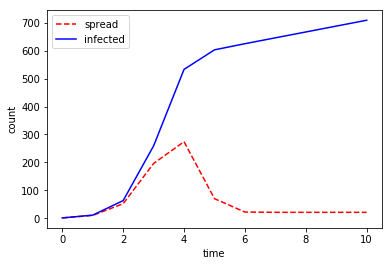

In [509]:
results.showSpreading(tag)

### Barabasi-Albert graph

In [510]:
url = gephiURL(host, port, 4)
tag = "dynamic-ba-additive-only"

In [511]:
graph4 = baGraph()

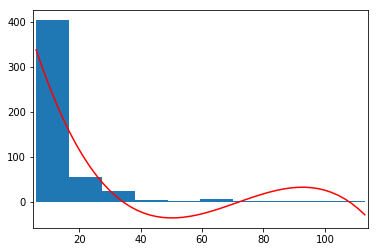

In [512]:
showDegreeDistributionWithFit(graph4)

In [513]:
%%time
gephiGraphNx(graph4)

CPU times: user 8.59 s, sys: 1.19 s, total: 9.79 s
Wall time: 12.1 s


In [514]:
averageDegree(graph4)

13.484

In [515]:
graphDegreeTopN(graph4)

N    Node     Degree  
---- -------- --------
   1       10      113
   2        1       96
   3        5       88
   4        3       74
   5        0       70
   6        2       69
   7        6       67
   8        7       65
   9       19       64
  10        4       63


In [516]:
results.store(tag, simulate(graph4, AdditiveOnly(graph4), Simulation.max_iterations))

time:    1 spread from: 163 -> 46
time:    1 spread from: 163 -> 140
time:    1 spread from: 163 -> 129
time:    1 spread from: 163 -> 62
time:    1 spread from: 163 -> 32
time:    1 spread from: 163 -> 111
time:    1 spread from: 163 -> 5
time:    1 spread from: 163 -> 199
time:    1 spread from: 163 -> 201
time:    1 spread from: 163 -> 235
time:    1 spread from: 163 -> 287
time:    1 spread from: 163 -> 353
time:    1 spread from: 163 -> 359
time:    1 spread from: 163 -> 390
time:    1 spread from: 163 -> 409
time:    1 spread from: 163 -> 429
time:    1 spread from: 163 -> 500
time:    1 spread from: 163 -> 506
time:    1 spread from: 163 -> 509
time:    2 spread from: 5 -> 0
time:    2 spread from: 5 -> 1
time:    2 spread from: 5 -> 2
time:    2 spread from: 5 -> 3
time:    2 spread from: 5 -> 4
time:    2 spread from: 5 -> 6
time:    2 spread from: 5 -> 7
time:    2 spread from: 5 -> 9
time:    2 spread from: 5 -> 10
time:    2 spread from: 5 -> 12
time:    2 spread from: 5 ->

time:    2 spread from: 509 -> 197
time:    2 spread from: 509 -> 274
time:    2 spread from: 509 -> 381
time:    2 spread from: 509 -> 257
time:    2 spread from: 509 -> 522
time:    3 spread from: 0 -> 8
time:    3 spread from: 0 -> 20
time:    3 spread from: 0 -> 24
time:    3 spread from: 0 -> 31
time:    3 spread from: 0 -> 38
time:    3 spread from: 0 -> 41
time:    3 spread from: 0 -> 45
time:    3 spread from: 0 -> 66
time:    3 spread from: 0 -> 68
time:    3 spread from: 0 -> 76
time:    3 spread from: 0 -> 81
time:    3 spread from: 0 -> 89
time:    3 spread from: 0 -> 92
time:    3 spread from: 0 -> 103
time:    3 spread from: 0 -> 156
time:    3 spread from: 0 -> 174
time:    3 spread from: 0 -> 190
time:    3 spread from: 0 -> 227
time:    3 spread from: 0 -> 251
time:    3 spread from: 0 -> 293
time:    3 spread from: 0 -> 316
time:    3 spread from: 0 -> 328
time:    3 spread from: 0 -> 337
time:    3 spread from: 0 -> 340
time:    3 spread from: 0 -> 349
time:    3 spr

time:    3 spread from: 30 -> 550
time:    3 spread from: 34 -> 516
time:    3 spread from: 39 -> 231
time:    3 spread from: 39 -> 310
time:    3 spread from: 39 -> 344
time:    3 spread from: 40 -> 260
time:    3 spread from: 40 -> 428
time:    3 spread from: 42 -> 450
time:    3 spread from: 42 -> 488
time:    3 spread from: 42 -> 528
time:    3 spread from: 43 -> 286
time:    3 spread from: 43 -> 393
time:    3 spread from: 43 -> 546
time:    3 spread from: 43 -> 554
time:    3 spread from: 44 -> 362
time:    3 spread from: 48 -> 261
time:    3 spread from: 48 -> 276
time:    3 spread from: 49 -> 358
time:    3 spread from: 49 -> 557
time:    3 spread from: 52 -> 524
time:    3 spread from: 52 -> 551
time:    3 spread from: 53 -> 476
time:    3 spread from: 54 -> 363
time:    3 spread from: 55 -> 326
time:    3 spread from: 55 -> 438
time:    3 spread from: 56 -> 433
time:    3 spread from: 56 -> 562
time:    3 spread from: 57 -> 487
time:    3 spread from: 57 -> 498
time:    3 spr

In [517]:
results.showResultsTable(tag)

,time,spread_count,spread_total,growth_count,growth_total,destruction_count,destruction_total
0,0,1,1,0,0,NaN,NaN
1,1,19,20,20,20,NaN,NaN
2,2,230,250,20,40,NaN,NaN
3,3,313,563,20,60,NaN,NaN
4,4,21,584,20,80,NaN,NaN
5,5,21,605,20,100,NaN,NaN
6,6,21,626,20,120,NaN,NaN
7,7,21,647,20,140,NaN,NaN
8,8,21,668,20,160,NaN,NaN
9,9,21,689,20,180,NaN,NaN


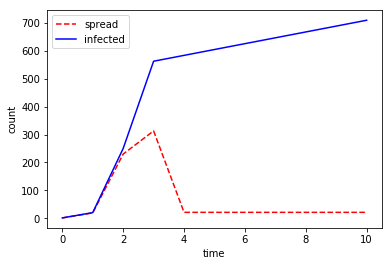

In [518]:
results.showSpreading(tag)

## Dynamic Graphs - spreading with addative and random detractive

### Erdos-Renyi (random) graph

In [519]:
url = gephiURL(host, port, 5)
tag = "dynamic-er-additive-with-random-detractive"

In [520]:
graph5 = randomGraph()

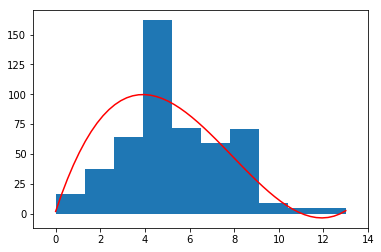

In [521]:
showDegreeDistributionWithFit(graph5)

In [522]:
%%time
gephiGraphNx(graph5)

CPU times: user 4.14 s, sys: 573 ms, total: 4.72 s
Wall time: 5.82 s


In [523]:
averageDegree(graph5)

5.308

In [524]:
results.store(tag, simulate(graph5, AddativeWithFixedRandomDetractive(graph5), Simulation.max_iterations))

time:    1 spread from: 445 -> 4
time:    1 spread from: 445 -> 126
time:    1 spread from: 445 -> 230
time:    1 spread from: 445 -> 256
time:    1 spread from: 445 -> 307
time:    1 spread from: 445 -> 311
time:    2 spread from: 4 -> 207
time:    2 spread from: 4 -> 332
time:    2 spread from: 4 -> 399
time:    2 spread from: 126 -> 19
time:    2 spread from: 126 -> 68
time:    2 spread from: 126 -> 113
time:    2 spread from: 126 -> 408
time:    2 spread from: 230 -> 107
time:    2 spread from: 230 -> 189
time:    2 spread from: 230 -> 213
time:    2 spread from: 230 -> 279
time:    2 spread from: 230 -> 285
time:    2 spread from: 230 -> 356
time:    2 spread from: 230 -> 425
time:    2 spread from: 230 -> 429
time:    2 spread from: 230 -> 436
time:    2 spread from: 256 -> 56
time:    2 spread from: 256 -> 361
time:    2 spread from: 256 -> 370
time:    2 spread from: 256 -> 520
time:    2 spread from: 307 -> 12
time:    2 spread from: 307 -> 125
time:    2 spread from: 307 -> 1

time:    4 spread from: 93 -> 582
time:    4 spread from: 110 -> 147
time:    4 spread from: 112 -> 188
time:    4 spread from: 112 -> 197
time:    4 spread from: 112 -> 322
time:    4 spread from: 112 -> 323
time:    4 spread from: 112 -> 387
time:    4 spread from: 112 -> 472
time:    4 spread from: 114 -> 276
time:    4 spread from: 115 -> 3
time:    4 spread from: 115 -> 94
time:    4 spread from: 115 -> 433
time:    4 spread from: 115 -> 440
time:    4 spread from: 115 -> 449
time:    4 spread from: 123 -> 288
time:    4 spread from: 123 -> 475
time:    4 spread from: 127 -> 176
time:    4 spread from: 127 -> 422
time:    4 spread from: 127 -> 477
time:    4 spread from: 127 -> 542
time:    4 spread from: 128 -> 143
time:    4 spread from: 128 -> 201
time:    4 spread from: 128 -> 203
time:    4 spread from: 137 -> 7
time:    4 spread from: 137 -> 105
time:    4 spread from: 137 -> 212
time:    4 spread from: 139 -> 320
time:    4 spread from: 139 -> 412
time:    4 spread from: 13

time:    5 spread from: 323 -> 586
time:    5 spread from: 328 -> 597
time:    5 spread from: 331 -> 74
time:    5 spread from: 339 -> 421
time:    5 spread from: 342 -> 35
time:    5 spread from: 342 -> 198
time:    5 spread from: 344 -> 604
time:    5 spread from: 345 -> 42
time:    5 spread from: 348 -> 455
time:    5 spread from: 352 -> 506
time:    5 spread from: 374 -> 235
time:    5 spread from: 378 -> 104
time:    5 spread from: 387 -> 263
time:    5 spread from: 440 -> 301
time:    5 spread from: 453 -> 463
time:    5 spread from: 457 -> 129
time:    5 spread from: 475 -> 165
time:    5 spread from: 511 -> 452
time:    5 spread from: 582 -> 267
time:    6 spread from: 3 -> 614
time:    6 spread from: 9 -> 623
time:    6 spread from: 13 -> 293
time:    6 spread from: 18 -> 624
time:    6 spread from: 23 -> 621
time:    6 spread from: 26 -> 609
time:    6 spread from: 47 -> 611
time:    6 spread from: 63 -> 615
time:    6 spread from: 69 -> 618
time:    6 spread from: 93 -> 613


In [525]:
results.showResultsTable(tag)

,time,spread_count,spread_total,growth_count,growth_total,destruction_count,destruction_total
0,0,1,1,0,0,0,0
1,1,6,7,20,20,20,20
2,2,31,38,20,40,20,40
3,3,124,162,20,60,20,60
4,4,253,415,20,80,20,80
5,5,114,529,20,100,20,100
6,6,21,550,20,120,20,120
7,7,21,571,20,140,20,140
8,8,19,590,20,160,20,160
9,9,20,610,20,180,20,180


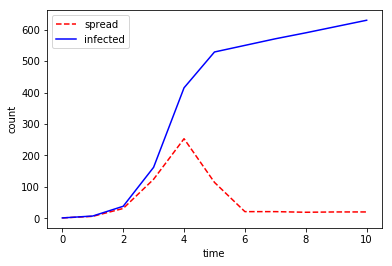

In [526]:
results.showSpreading(tag)

### Barabasi-Albert graph

In [527]:
url = gephiURL(host, port, 6)
tag = "dynamic-ba-additive-with-random-detractive"

In [528]:
graph6 = baGraph()

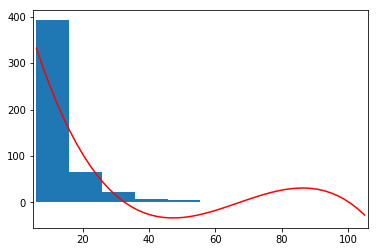

In [529]:
showDegreeDistributionWithFit(graph6)

In [530]:
%%time
gephiGraphNx(graph6)

CPU times: user 9.16 s, sys: 1.28 s, total: 10.4 s
Wall time: 13 s


In [531]:
averageDegree(graph6)

13.5

In [532]:
graphDegreeTopN(graph6)

N    Node     Degree  
---- -------- --------
   1        1      105
   2        3       94
   3        6       90
   4        2       85
   5        4       80
   6        9       70
   7        5       61
   8       13       60
   9       25       54
  10        8       51


In [533]:
results.store(tag, simulate(graph6, AddativeWithFixedRandomDetractive(graph6), Simulation.max_iterations))

time:    1 spread from: 397 -> 13
time:    1 spread from: 397 -> 24
time:    1 spread from: 397 -> 136
time:    1 spread from: 397 -> 237
time:    1 spread from: 397 -> 6
time:    1 spread from: 397 -> 163
time:    1 spread from: 397 -> 332
time:    1 spread from: 397 -> 433
time:    1 spread from: 397 -> 506
time:    1 spread from: 397 -> 509
time:    2 spread from: 6 -> 0
time:    2 spread from: 6 -> 1
time:    2 spread from: 6 -> 2
time:    2 spread from: 6 -> 3
time:    2 spread from: 6 -> 4
time:    2 spread from: 6 -> 5
time:    2 spread from: 6 -> 7
time:    2 spread from: 6 -> 9
time:    2 spread from: 6 -> 10
time:    2 spread from: 6 -> 11
time:    2 spread from: 6 -> 12
time:    2 spread from: 6 -> 14
time:    2 spread from: 6 -> 15
time:    2 spread from: 6 -> 17
time:    2 spread from: 6 -> 18
time:    2 spread from: 6 -> 19
time:    2 spread from: 6 -> 20
time:    2 spread from: 6 -> 21
time:    2 spread from: 6 -> 22
time:    2 spread from: 6 -> 26
time:    2 spread from

time:    3 spread from: 1 -> 514
time:    3 spread from: 2 -> 32
time:    3 spread from: 2 -> 63
time:    3 spread from: 2 -> 69
time:    3 spread from: 2 -> 80
time:    3 spread from: 2 -> 92
time:    3 spread from: 2 -> 110
time:    3 spread from: 2 -> 141
time:    3 spread from: 2 -> 167
time:    3 spread from: 2 -> 168
time:    3 spread from: 2 -> 179
time:    3 spread from: 2 -> 215
time:    3 spread from: 2 -> 240
time:    3 spread from: 2 -> 244
time:    3 spread from: 2 -> 248
time:    3 spread from: 2 -> 253
time:    3 spread from: 2 -> 271
time:    3 spread from: 2 -> 277
time:    3 spread from: 2 -> 297
time:    3 spread from: 2 -> 303
time:    3 spread from: 2 -> 313
time:    3 spread from: 2 -> 321
time:    3 spread from: 2 -> 327
time:    3 spread from: 2 -> 384
time:    3 spread from: 2 -> 395
time:    3 spread from: 2 -> 414
time:    3 spread from: 2 -> 419
time:    3 spread from: 2 -> 421
time:    3 spread from: 2 -> 428
time:    3 spread from: 2 -> 432
time:    3 spre

time:    3 spread from: 490 -> 505
time:    4 spread from: 3 -> 566
time:    4 spread from: 3 -> 583
time:    4 spread from: 5 -> 563
time:    4 spread from: 5 -> 575
time:    4 spread from: 6 -> 579
time:    4 spread from: 13 -> 574
time:    4 spread from: 16 -> 577
time:    4 spread from: 17 -> 571
time:    4 spread from: 19 -> 578
time:    4 spread from: 22 -> 567
time:    4 spread from: 22 -> 570
time:    4 spread from: 22 -> 573
time:    4 spread from: 26 -> 568
time:    4 spread from: 29 -> 582
time:    4 spread from: 32 -> 581
time:    4 spread from: 34 -> 569
time:    4 spread from: 40 -> 564
time:    4 spread from: 49 -> 572
time:    4 spread from: 50 -> 576
time:    4 spread from: 70 -> 565
time:    4 spread from: 73 -> 580
time:    5 spread from: 12 -> 585
time:    5 spread from: 12 -> 590
time:    5 spread from: 19 -> 604
time:    5 spread from: 20 -> 584
time:    5 spread from: 20 -> 601
time:    5 spread from: 28 -> 591
time:    5 spread from: 32 -> 599
time:    5 spread 

In [534]:
results.showResultsTable(tag)

,time,spread_count,spread_total,growth_count,growth_total,destruction_count,destruction_total
0,0,1,1,0,0,0,0
1,1,10,11,20,20,20,20
2,2,188,199,20,40,20,40
3,3,314,513,20,60,20,60
4,4,21,534,20,80,20,80
5,5,21,555,20,100,20,100
6,6,20,575,20,120,20,120
7,7,21,596,20,140,20,140
8,8,19,615,20,160,20,160
9,9,20,635,20,180,20,180


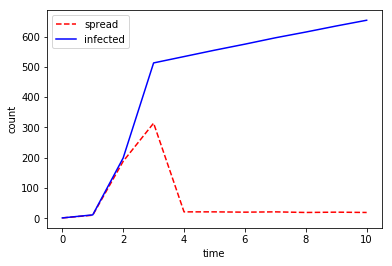

In [535]:
results.showSpreading(tag)

In [536]:
graphDegreeTopN(graph6)

N    Node     Degree  
---- -------- --------
   1        1       77
   2        3       73
   3        2       68
   4        4       63
   5        6       59
   6        5       47
   7       13       44
   8       19       44
   9        0       39
  10       34       39


## Dynamic Graphs - addative and targeted detractive

### Erdos-Renyi (random) graph

In [537]:
url = gephiURL(host, port, 7)
tag = "dynamic-er-additive-with-targeted-detractive"

In [538]:
graph7 = randomGraph()

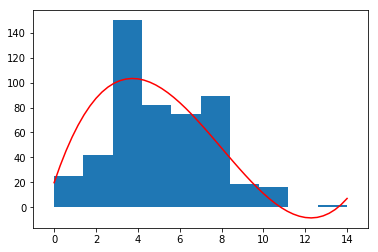

In [539]:
showDegreeDistributionWithFit(graph7)

In [540]:
%%time
gephiGraphNx(graph7)

CPU times: user 4 s, sys: 559 ms, total: 4.55 s
Wall time: 5.8 s


In [541]:
averageDegree(graph7)

5.02

In [542]:
graphDegreeTopN(graph7)

N    Node     Degree  
---- -------- --------
   1      274       14
   2      253       13
   3      131       11
   4      185       11
   5      197       11
   6      407       11
   7      411       11
   8       25       10
   9      117       10
  10      125       10


In [543]:
results.store(tag, simulate(graph7, AddativeWithTargetedDetractive(graph7), Simulation.max_iterations))

time:    1 spread from: 419 -> 25
time:    1 spread from: 419 -> 56
time:    1 spread from: 419 -> 140
time:    1 spread from: 419 -> 143
time:    1 spread from: 419 -> 254
time:    1 spread from: 419 -> 278
time:    1 spread from: 419 -> 417
time:    1 spread from: 419 -> 487
time:    2 spread from: 25 -> 11
time:    2 spread from: 25 -> 51
time:    2 spread from: 25 -> 229
time:    2 spread from: 25 -> 246
time:    2 spread from: 25 -> 264
time:    2 spread from: 25 -> 286
time:    2 spread from: 25 -> 288
time:    2 spread from: 25 -> 389
time:    2 spread from: 25 -> 423
time:    2 spread from: 56 -> 20
time:    2 spread from: 56 -> 276
time:    2 spread from: 56 -> 369
time:    2 spread from: 56 -> 416
time:    2 spread from: 56 -> 443
time:    2 spread from: 56 -> 528
time:    2 spread from: 140 -> 10
time:    2 spread from: 140 -> 33
time:    2 spread from: 140 -> 193
time:    2 spread from: 140 -> 321
time:    2 spread from: 140 -> 348
time:    2 spread from: 140 -> 356
time:  

time:    4 spread from: 0 -> 529
time:    4 spread from: 1 -> 371
time:    4 spread from: 2 -> 69
time:    4 spread from: 2 -> 132
time:    4 spread from: 2 -> 436
time:    4 spread from: 2 -> 467
time:    4 spread from: 2 -> 564
time:    4 spread from: 2 -> 572
time:    4 spread from: 5 -> 273
time:    4 spread from: 13 -> 154
time:    4 spread from: 13 -> 244
time:    4 spread from: 13 -> 351
time:    4 spread from: 13 -> 418
time:    4 spread from: 14 -> 6
time:    4 spread from: 14 -> 160
time:    4 spread from: 14 -> 249
time:    4 spread from: 14 -> 344
time:    4 spread from: 14 -> 459
time:    4 spread from: 19 -> 396
time:    4 spread from: 19 -> 422
time:    4 spread from: 19 -> 536
time:    4 spread from: 19 -> 540
time:    4 spread from: 19 -> 557
time:    4 spread from: 23 -> 66
time:    4 spread from: 23 -> 70
time:    4 spread from: 23 -> 156
time:    4 spread from: 23 -> 500
time:    4 spread from: 25 -> 583
time:    4 spread from: 28 -> 347
time:    4 spread from: 28 -

time:    4 spread from: 341 -> 581
time:    4 spread from: 350 -> 7
time:    4 spread from: 352 -> 320
time:    4 spread from: 357 -> 225
time:    4 spread from: 358 -> 398
time:    4 spread from: 359 -> 336
time:    4 spread from: 359 -> 582
time:    4 spread from: 360 -> 45
time:    4 spread from: 360 -> 263
time:    4 spread from: 368 -> 311
time:    4 spread from: 368 -> 426
time:    4 spread from: 379 -> 236
time:    4 spread from: 383 -> 498
time:    4 spread from: 388 -> 290
time:    4 spread from: 388 -> 490
time:    4 spread from: 390 -> 334
time:    4 spread from: 392 -> 300
time:    4 spread from: 400 -> 338
time:    4 spread from: 403 -> 533
time:    4 spread from: 407 -> 191
time:    4 spread from: 407 -> 425
time:    4 spread from: 421 -> 47
time:    4 spread from: 424 -> 492
time:    4 spread from: 430 -> 516
time:    4 spread from: 445 -> 67
time:    4 spread from: 445 -> 466
time:    4 spread from: 447 -> 194
time:    4 spread from: 455 -> 410
time:    4 spread from: 4

In [544]:
results.showResultsTable(tag)

,time,spread_count,spread_total,growth_count,growth_total,destruction_count,destruction_total
0,0,1,1,0,0,0,0
1,1,8,9,20,20,1,1
2,2,46,55,20,40,1,2
3,3,192,247,20,60,1,3
4,4,285,532,20,80,1,4
5,5,67,599,20,100,1,5
6,6,22,621,20,120,1,6
7,7,22,643,20,140,1,7
8,8,21,664,20,160,1,8
9,9,21,685,20,180,1,9


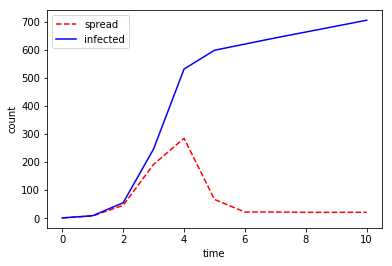

In [545]:
results.showSpreading(tag)

In [546]:
graphDegreeTopN(graph7)

N    Node     Degree  
---- -------- --------
   1      112       13
   2      354       13
   3       57       12
   4      197       12
   5      248       12
   6      366       12
   7      407       12
   8      447       12
   9      482       12
  10       19       11


### Barabasi-Albert graph

In [547]:
url = gephiURL(host, port, 8)
tag = "dynamic-ba-additive-with-targeted-detractive"

In [548]:
graph8 = baGraph()

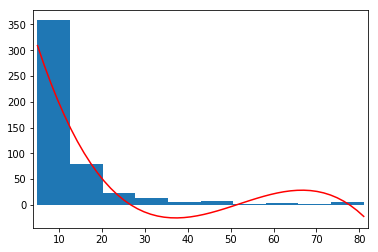

In [549]:
showDegreeDistributionWithFit(graph8)

In [550]:
%%time
gephiGraphNx(graph8)

CPU times: user 8.56 s, sys: 1.2 s, total: 9.77 s
Wall time: 12 s


In [551]:
averageDegree(graph8)

13.48

In [552]:
graphDegreeTopN(graph8)

N    Node     Degree  
---- -------- --------
   1        4       81
   2        0       75
   3        1       75
   4        3       75
   5        7       74
   6        2       72
   7        5       68
   8        6       64
   9        8       61
  10       20       60


In [553]:
results.store(tag, simulate(graph8, AddativeWithTargetedDetractive(graph8), Simulation.max_iterations))

time:    1 spread from: 395 -> 86
time:    1 spread from: 395 -> 159
time:    1 spread from: 395 -> 32
time:    1 spread from: 395 -> 52
time:    1 spread from: 395 -> 190
time:    1 spread from: 395 -> 248
time:    1 spread from: 395 -> 8
time:    1 spread from: 395 -> 509
time:    2 spread from: 8 -> 5
time:    2 spread from: 8 -> 7
time:    2 spread from: 8 -> 6
time:    2 spread from: 8 -> 10
time:    2 spread from: 8 -> 12
time:    2 spread from: 8 -> 20
time:    2 spread from: 8 -> 21
time:    2 spread from: 8 -> 25
time:    2 spread from: 8 -> 26
time:    2 spread from: 8 -> 30
time:    2 spread from: 8 -> 39
time:    2 spread from: 8 -> 44
time:    2 spread from: 8 -> 45
time:    2 spread from: 8 -> 51
time:    2 spread from: 8 -> 63
time:    2 spread from: 8 -> 69
time:    2 spread from: 8 -> 70
time:    2 spread from: 8 -> 82
time:    2 spread from: 8 -> 90
time:    2 spread from: 8 -> 112
time:    2 spread from: 8 -> 116
time:    2 spread from: 8 -> 135
time:    2 spread fro

time:    3 spread from: 5 -> 130
time:    3 spread from: 5 -> 131
time:    3 spread from: 5 -> 138
time:    3 spread from: 5 -> 175
time:    3 spread from: 5 -> 186
time:    3 spread from: 5 -> 194
time:    3 spread from: 5 -> 215
time:    3 spread from: 5 -> 258
time:    3 spread from: 5 -> 317
time:    3 spread from: 5 -> 328
time:    3 spread from: 5 -> 345
time:    3 spread from: 5 -> 353
time:    3 spread from: 5 -> 355
time:    3 spread from: 5 -> 358
time:    3 spread from: 5 -> 479
time:    3 spread from: 5 -> 493
time:    3 spread from: 6 -> 36
time:    3 spread from: 6 -> 48
time:    3 spread from: 6 -> 65
time:    3 spread from: 6 -> 109
time:    3 spread from: 6 -> 168
time:    3 spread from: 6 -> 183
time:    3 spread from: 6 -> 193
time:    3 spread from: 6 -> 222
time:    3 spread from: 6 -> 245
time:    3 spread from: 6 -> 247
time:    3 spread from: 6 -> 266
time:    3 spread from: 6 -> 290
time:    3 spread from: 6 -> 292
time:    3 spread from: 6 -> 301
time:    3 sp

time:    3 spread from: 70 -> 524
time:    3 spread from: 72 -> 295
time:    3 spread from: 72 -> 539
time:    3 spread from: 73 -> 544
time:    3 spread from: 78 -> 389
time:    3 spread from: 78 -> 538
time:    3 spread from: 80 -> 461
time:    3 spread from: 82 -> 556
time:    3 spread from: 84 -> 523
time:    3 spread from: 90 -> 438
time:    3 spread from: 91 -> 444
time:    3 spread from: 94 -> 188
time:    3 spread from: 94 -> 504
time:    3 spread from: 111 -> 548
time:    3 spread from: 115 -> 510
time:    3 spread from: 116 -> 530
time:    3 spread from: 132 -> 555
time:    3 spread from: 135 -> 322
time:    3 spread from: 144 -> 512
time:    3 spread from: 147 -> 547
time:    3 spread from: 150 -> 442
time:    3 spread from: 152 -> 280
time:    3 spread from: 152 -> 551
time:    3 spread from: 160 -> 232
time:    3 spread from: 160 -> 359
time:    3 spread from: 164 -> 532
time:    3 spread from: 180 -> 399
time:    3 spread from: 181 -> 549
time:    3 spread from: 187 -> 43

In [554]:
results.showResultsTable(tag)

,time,spread_count,spread_total,growth_count,growth_total,destruction_count,destruction_total
0,0,1,1,0,0,0,0
1,1,8,9,20,20,1,1
2,2,145,154,20,40,1,2
3,3,403,557,20,60,1,3
4,4,24,581,20,80,1,4
5,5,21,602,20,100,1,5
6,6,21,623,20,120,1,6
7,7,21,644,20,140,1,7
8,8,21,665,20,160,1,8
9,9,21,686,20,180,1,9


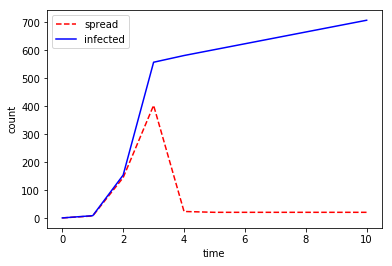

In [555]:
results.showSpreading(tag)

In [556]:
graphDegreeTopN(graph8)

N    Node     Degree  
---- -------- --------
   1        8       58
   2       22       55
   3       17       54
   4       19       52
   5        9       49
   6       31       47
   7       52       47
   8       11       46
   9       15       46
  10       30       45


## Dynamic Graphs - addative and invasive detractive

### Erdos-Renyi (random) graph

In [557]:
url = gephiURL(host, port, 9)
tag = "dynamic-er-additive-with-invasive-detractive"

In [558]:
graph9 = randomGraph()

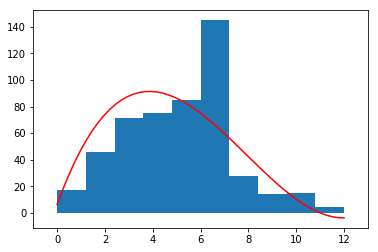

In [559]:
showDegreeDistributionWithFit(graph9)

In [560]:
%%time
gephiGraphNx(graph9)

CPU times: user 4.26 s, sys: 620 ms, total: 4.88 s
Wall time: 6.16 s


In [561]:
averageDegree(graph9)

5.036

In [562]:
graphDegreeTopN(graph9)

N    Node     Degree  
---- -------- --------
   1      327       12
   2      373       12
   3       15       11
   4      216       11
   5        2       10
   6        8       10
   7       44       10
   8       63       10
   9       65       10
  10       79       10


In [563]:
results.store(tag, simulate(graph9, AddativeWithInvasiveDetractive(graph9), Simulation.max_iterations))

time:    1 spread from: 16 -> 71
time:    1 spread from: 16 -> 100
time:    1 spread from: 16 -> 262
time:    1 spread from: 16 -> 316
time:    1 spread from: 16 -> 369
time:    2 spread from: 71 -> 68
time:    2 spread from: 71 -> 302
time:    2 spread from: 71 -> 498
time:    2 spread from: 262 -> 186
time:    2 spread from: 262 -> 201
time:    2 spread from: 262 -> 323
time:    2 spread from: 262 -> 345
time:    2 spread from: 369 -> 307
time:    2 spread from: 369 -> 385
time:    2 spread from: 369 -> 396
time:    2 spread from: 369 -> 407
time:    2 spread from: 369 -> 460
time:    3 spread from: 68 -> 69
time:    3 spread from: 68 -> 187
time:    3 spread from: 68 -> 381
time:    3 spread from: 186 -> 93
time:    3 spread from: 186 -> 159
time:    3 spread from: 186 -> 288
time:    3 spread from: 186 -> 484
time:    3 spread from: 186 -> 521
time:    3 spread from: 201 -> 147
time:    3 spread from: 201 -> 236
time:    3 spread from: 201 -> 354
time:    3 spread from: 201 -> 383


time:    5 spread from: 35 -> 20
time:    5 spread from: 35 -> 175
time:    5 spread from: 35 -> 315
time:    5 spread from: 38 -> 89
time:    5 spread from: 38 -> 571
time:    5 spread from: 41 -> 603
time:    5 spread from: 49 -> 220
time:    5 spread from: 49 -> 374
time:    5 spread from: 49 -> 480
time:    5 spread from: 53 -> 54
time:    5 spread from: 53 -> 332
time:    5 spread from: 53 -> 421
time:    5 spread from: 64 -> 82
time:    5 spread from: 64 -> 520
time:    5 spread from: 66 -> 31
time:    5 spread from: 66 -> 227
time:    5 spread from: 73 -> 349
time:    5 spread from: 73 -> 401
time:    5 spread from: 85 -> 203
time:    5 spread from: 85 -> 572
time:    5 spread from: 98 -> 584
time:    5 spread from: 99 -> 182
time:    5 spread from: 103 -> 284
time:    5 spread from: 103 -> 479
time:    5 spread from: 106 -> 277
time:    5 spread from: 106 -> 293
time:    5 spread from: 107 -> 337
time:    5 spread from: 107 -> 564
time:    5 spread from: 117 -> 211
time:    5 s

time:    6 spread from: 61 -> 353
time:    6 spread from: 71 -> 616
time:    6 spread from: 74 -> 611
time:    6 spread from: 82 -> 526
time:    6 spread from: 82 -> 608
time:    6 spread from: 86 -> 610
time:    6 spread from: 92 -> 119
time:    6 spread from: 92 -> 155
time:    6 spread from: 94 -> 84
time:    6 spread from: 101 -> 139
time:    6 spread from: 104 -> 543
time:    6 spread from: 107 -> 614
time:    6 spread from: 108 -> 540
time:    6 spread from: 110 -> 423
time:    6 spread from: 110 -> 501
time:    6 spread from: 112 -> 137
time:    6 spread from: 112 -> 617
time:    6 spread from: 115 -> 424
time:    6 spread from: 115 -> 623
time:    6 spread from: 118 -> 224
time:    6 spread from: 125 -> 615
time:    6 spread from: 126 -> 165
time:    6 spread from: 126 -> 559
time:    6 spread from: 131 -> 618
time:    6 spread from: 133 -> 308
time:    6 spread from: 142 -> 554
time:    6 spread from: 146 -> 607
time:    6 spread from: 149 -> 351
time:    6 spread from: 150 ->

In [564]:
results.showResultsTable(tag)

,time,spread_count,spread_total,growth_count,growth_total,destruction_count,destruction_total
0,0,1,1,0,0,0,0
1,1,5,6,20,20,13,13
2,2,12,18,20,40,13,26
3,3,46,64,20,60,13,39
4,4,148,212,20,80,13,52
5,5,246,458,20,100,13,65
6,6,103,561,20,120,14,79
7,7,27,588,20,140,14,93
8,8,22,610,20,160,14,107
9,9,22,632,20,180,14,121


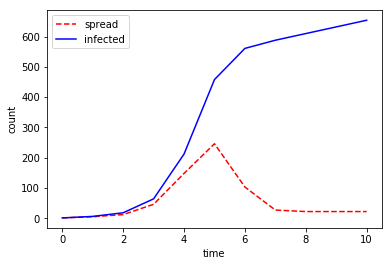

In [565]:
results.showSpreading(tag)

In [566]:
graphDegreeTopN(graph9)

N    Node     Degree  
---- -------- --------
   1      292        7
   2      303        7
   3      332        7
   4      333        7
   5      346        7
   6      380        7
   7      383        7
   8      438        7
   9      440        7
  10      441        7


### Barabasi-Albert graph

In [567]:
url = gephiURL(host, port, 10)
tag = "dynamic-ba-additive-with-invasive-detractive"

In [568]:
graph10 = baGraph()

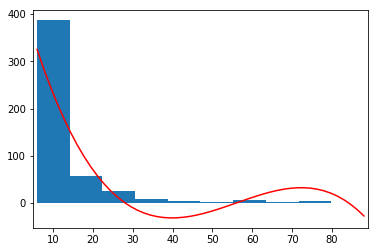

In [569]:
showDegreeDistributionWithFit(graph10)

In [570]:
%%time
gephiGraphNx(graph10)

CPU times: user 9.17 s, sys: 1.31 s, total: 10.5 s
Wall time: 12.9 s


In [571]:
averageDegree(graph10)

13.504

In [572]:
graphDegreeTopN(graph10)

N    Node     Degree  
---- -------- --------
   1        5       88
   2        1       76
   3       11       76
   4        0       75
   5        7       75
   6        9       70
   7        6       69
   8       20       64
   9       12       63
  10       10       62


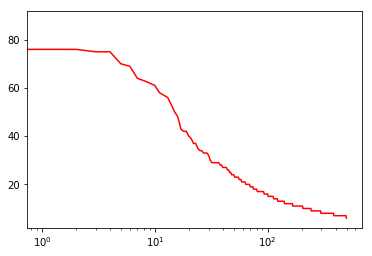

In [573]:
showDegreeDistributionLogScale(graph10)

In [574]:
results.store(tag, simulate(graph10, AddativeWithInvasiveDetractive(graph10), Simulation.max_iterations))

time:    1 spread from: 294 -> 206
time:    1 spread from: 294 -> 258
time:    1 spread from: 294 -> 28
time:    1 spread from: 294 -> 205
time:    1 spread from: 294 -> 113
time:    1 spread from: 294 -> 431
time:    1 spread from: 294 -> 504
time:    2 spread from: 113 -> 61
time:    2 spread from: 113 -> 54
time:    2 spread from: 113 -> 79
time:    2 spread from: 113 -> 67
time:    2 spread from: 113 -> 136
time:    2 spread from: 113 -> 174
time:    2 spread from: 113 -> 175
time:    2 spread from: 113 -> 187
time:    2 spread from: 113 -> 188
time:    2 spread from: 113 -> 217
time:    2 spread from: 113 -> 224
time:    2 spread from: 113 -> 244
time:    2 spread from: 113 -> 256
time:    2 spread from: 113 -> 266
time:    2 spread from: 113 -> 303
time:    2 spread from: 113 -> 308
time:    2 spread from: 113 -> 370
time:    2 spread from: 113 -> 534
time:    2 spread from: 205 -> 78
time:    2 spread from: 205 -> 16
time:    2 spread from: 205 -> 167
time:    2 spread from: 205

time:    3 spread from: 187 -> 492
time:    3 spread from: 187 -> 518
time:    3 spread from: 187 -> 539
time:    3 spread from: 187 -> 548
time:    3 spread from: 188 -> 144
time:    3 spread from: 188 -> 199
time:    3 spread from: 188 -> 200
time:    3 spread from: 188 -> 398
time:    3 spread from: 189 -> 141
time:    3 spread from: 189 -> 104
time:    3 spread from: 189 -> 382
time:    3 spread from: 205 -> 543
time:    3 spread from: 214 -> 503
time:    3 spread from: 214 -> 560
time:    3 spread from: 217 -> 170
time:    3 spread from: 217 -> 360
time:    3 spread from: 217 -> 509
time:    3 spread from: 224 -> 85
time:    3 spread from: 224 -> 197
time:    3 spread from: 224 -> 432
time:    3 spread from: 244 -> 116
time:    3 spread from: 244 -> 208
time:    3 spread from: 244 -> 124
time:    3 spread from: 244 -> 272
time:    3 spread from: 244 -> 417
time:    3 spread from: 244 -> 450
time:    3 spread from: 244 -> 476
time:    3 spread from: 245 -> 100
time:    3 spread fro

time:    4 spread from: 223 -> 338
time:    4 spread from: 239 -> 376
time:    4 spread from: 241 -> 462
time:    4 spread from: 248 -> 297
time:    4 spread from: 265 -> 72
time:    4 spread from: 274 -> 322
time:    4 spread from: 278 -> 41
time:    4 spread from: 287 -> 306
time:    4 spread from: 296 -> 469
time:    4 spread from: 305 -> 261
time:    4 spread from: 305 -> 408
time:    4 spread from: 321 -> 578
time:    4 spread from: 334 -> 444
time:    4 spread from: 337 -> 545
time:    4 spread from: 340 -> 121
time:    4 spread from: 341 -> 403
time:    4 spread from: 341 -> 437
time:    4 spread from: 351 -> 247
time:    4 spread from: 400 -> 352
time:    4 spread from: 425 -> 304
time:    4 spread from: 501 -> 140
time:    4 spread from: 516 -> 122
time:    4 spread from: 533 -> 369
time:    5 spread from: 23 -> 593
time:    5 spread from: 35 -> 585
time:    5 spread from: 41 -> 599
time:    5 spread from: 48 -> 182
time:    5 spread from: 48 -> 584
time:    5 spread from: 48 

In [575]:
results.showResultsTable(tag)

,time,spread_count,spread_total,growth_count,growth_total,destruction_count,destruction_total
0,0,1,1,0,0,0,0
1,1,7,8,20,20,13,13
2,2,61,69,20,40,13,26
3,3,301,370,20,60,13,39
4,4,178,548,20,80,13,52
5,5,22,570,20,100,13,65
6,6,21,591,20,120,14,79
7,7,21,612,20,140,14,93
8,8,21,633,20,160,14,107
9,9,21,654,20,180,14,121


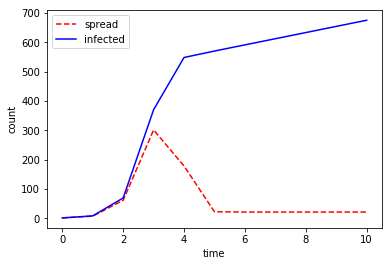

In [576]:
results.showSpreading(tag)

In [577]:
graphDegreeTopN(graph10)

N    Node     Degree  
---- -------- --------
   1      554       16
   2      556       16
   3      557       16
   4      568       16
   5      569       16
   6      619       16
   7      645       16
   8      657       16
   9      658       16
  10      668       16


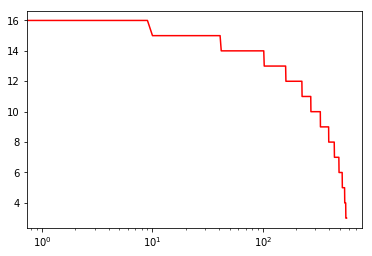

In [578]:
showDegreeDistributionLogScale(graph10)

## Dynamic Graphs - addative and extremely invasive detractive

### Erdos-Renyi (random) graph

In [579]:
url = gephiURL(host, port, 11)
tag = "dynamic-er-additive-with-extremely-invasive-detractive"

In [580]:
graph11 = randomGraph()

In [581]:
print(nx.info(graph11))

Name: 
Type: Graph
Number of nodes: 500
Number of edges: 1246
Average degree:   4.9840


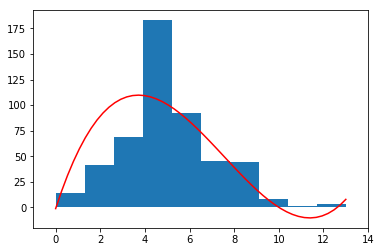

In [582]:
showDegreeDistributionWithFit(graph11)

In [583]:
%%time
gephiGraphNx(graph11)

CPU times: user 4.21 s, sys: 593 ms, total: 4.8 s
Wall time: 6.09 s


In [584]:
graphDegreeTopN(graph11)

N    Node     Degree  
---- -------- --------
   1      401       13
   2      230       12
   3      367       12
   4      483       11
   5       61       10
   6       73       10
   7      187       10
   8      298       10
   9      368       10
  10      378       10


In [585]:
results.store(tag, simulate(graph11, AddativeWithExtremeInvasiveDetractive(graph11), Simulation.max_iterations))

time:    1 spread from: 40 -> 118
time:    1 spread from: 40 -> 584
time:    1 spread from: 40 -> 641
time:    2 spread from: 40 -> 656
time:    2 spread from: 118 -> 364
time:    2 spread from: 118 -> 463
time:    2 spread from: 118 -> 630
time:    2 spread from: 118 -> 695
time:    2 spread from: 584 -> 189
time:    2 spread from: 641 -> 123
time:    2 spread from: 641 -> 698
time:    3 spread from: 123 -> 30
time:    3 spread from: 189 -> 214
time:    3 spread from: 189 -> 606
time:    3 spread from: 189 -> 690
time:    3 spread from: 364 -> 208
time:    3 spread from: 364 -> 318
time:    3 spread from: 364 -> 623
time:    3 spread from: 463 -> 534
time:    3 spread from: 630 -> 547
time:    3 spread from: 630 -> 677
time:    3 spread from: 656 -> 636
time:    3 spread from: 656 -> 340
time:    3 spread from: 656 -> 494
time:    3 spread from: 656 -> 752
time:    3 spread from: 695 -> 551
time:    3 spread from: 695 -> 69
time:    3 spread from: 698 -> 43
time:    3 spread from: 698

time:    7 spread from: 308 -> 913
time:    7 spread from: 311 -> 958
time:    7 spread from: 330 -> 292
time:    7 spread from: 330 -> 382
time:    7 spread from: 330 -> 936
time:    7 spread from: 340 -> 926
time:    7 spread from: 343 -> 430
time:    7 spread from: 343 -> 790
time:    7 spread from: 345 -> 943
time:    7 spread from: 374 -> 721
time:    7 spread from: 374 -> 930
time:    7 spread from: 385 -> 15
time:    7 spread from: 385 -> 747
time:    7 spread from: 385 -> 784
time:    7 spread from: 404 -> 949
time:    7 spread from: 407 -> 697
time:    7 spread from: 407 -> 769
time:    7 spread from: 407 -> 944
time:    7 spread from: 445 -> 811
time:    7 spread from: 452 -> 957
time:    7 spread from: 466 -> 952
time:    7 spread from: 474 -> 817
time:    7 spread from: 482 -> 755
time:    7 spread from: 482 -> 775
time:    7 spread from: 600 -> 776
time:    7 spread from: 600 -> 884
time:    7 spread from: 606 -> 910
time:    7 spread from: 621 -> 717
time:    7 spread fro

In [586]:
results.showResultsTable(tag)

,time,spread_count,spread_total,growth_count,growth_total,destruction_count,destruction_total
0,0,1,1,0,0,0,0
1,1,1,2,50,50,55,55
2,2,1,3,50,100,54,109
3,3,3,6,50,150,54,163
4,4,8,14,50,200,54,217
5,5,18,32,50,250,53,270
6,6,38,70,50,300,53,323
7,7,72,142,50,350,53,376
8,8,90,232,50,400,53,429
9,9,133,365,50,450,53,482


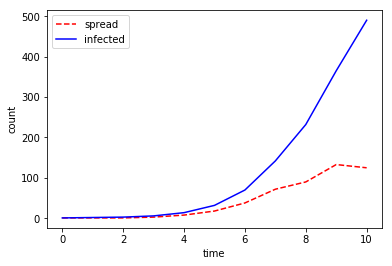

In [587]:
results.showSpreading(tag)

In [588]:
print(nx.info(graph11))

Name: 
Type: Graph
Number of nodes: 476
Number of edges: 608
Average degree:   2.5546


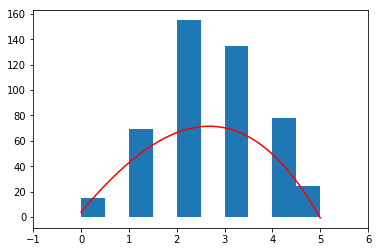

In [589]:
showDegreeDistributionWithFit(graph11)

In [590]:
graphDegreeTopN(graph11)

N    Node     Degree  
---- -------- --------
   1      727        5
   2      739        5
   3      744        5
   4      752        5
   5      763        5
   6      807        5
   7      814        5
   8      819        5
   9      826        5
  10      886        5


### Barabasi-Albert graph

In [591]:
url = gephiURL(host, port, 12)
tag = "dynamic-ba-additive-with-extremely-invasive-detractive"

In [592]:
graph12 = baGraph()

In [593]:
print(nx.info(graph12))

Name: 
Type: Graph
Number of nodes: 500
Number of edges: 3365
Average degree:  13.4600


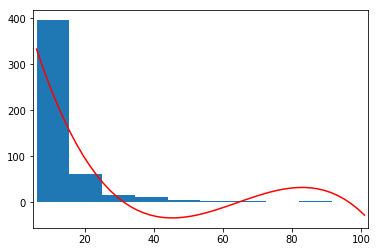

In [594]:
showDegreeDistributionWithFit(graph12)

In [595]:
%%time
gephiGraphNx(graph12)

CPU times: user 9.19 s, sys: 1.3 s, total: 10.5 s
Wall time: 13 s


In [596]:
graphDegreeTopN(graph12)

N    Node     Degree  
---- -------- --------
   1        1      101
   2        6       89
   3        5       84
   4        7       84
   5        4       74
   6        2       70
   7        3       67
   8        0       59
   9       11       55
  10       17       55


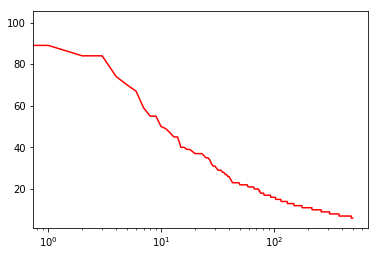

In [597]:
showDegreeDistributionLogScale(graph12)

In [598]:
results.store(tag, simulate(graph12, AddativeWithExtremeInvasiveDetractive(graph12), Simulation.max_iterations))

time:    1 spread from: 301 -> 213
time:    1 spread from: 301 -> 59
time:    1 spread from: 301 -> 145
time:    1 spread from: 301 -> 332
time:    1 spread from: 301 -> 389
time:    1 spread from: 301 -> 419
time:    1 spread from: 301 -> 480
time:    1 spread from: 301 -> 518
time:    2 spread from: 59 -> 55
time:    2 spread from: 59 -> 22
time:    2 spread from: 59 -> 102
time:    2 spread from: 59 -> 215
time:    2 spread from: 59 -> 260
time:    2 spread from: 59 -> 431
time:    2 spread from: 59 -> 468
time:    2 spread from: 59 -> 561
time:    2 spread from: 59 -> 572
time:    2 spread from: 145 -> 140
time:    2 spread from: 145 -> 118
time:    2 spread from: 145 -> 109
time:    2 spread from: 145 -> 189
time:    2 spread from: 145 -> 203
time:    2 spread from: 145 -> 352
time:    2 spread from: 145 -> 370
time:    2 spread from: 145 -> 472
time:    2 spread from: 145 -> 525
time:    2 spread from: 145 -> 543
time:    2 spread from: 145 -> 563
time:    2 spread from: 145 -> 5

time:    3 spread from: 541 -> 268
time:    3 spread from: 541 -> 338
time:    3 spread from: 541 -> 461
time:    3 spread from: 543 -> 255
time:    3 spread from: 543 -> 353
time:    3 spread from: 543 -> 232
time:    3 spread from: 543 -> 134
time:    3 spread from: 551 -> 177
time:    3 spread from: 551 -> 249
time:    3 spread from: 551 -> 312
time:    3 spread from: 551 -> 473
time:    3 spread from: 551 -> 207
time:    3 spread from: 551 -> 327
time:    3 spread from: 557 -> 93
time:    3 spread from: 557 -> 471
time:    3 spread from: 557 -> 334
time:    3 spread from: 557 -> 343
time:    3 spread from: 557 -> 477
time:    3 spread from: 557 -> 611
time:    3 spread from: 561 -> 355
time:    3 spread from: 561 -> 404
time:    3 spread from: 561 -> 493
time:    3 spread from: 561 -> 482
time:    3 spread from: 561 -> 424
time:    3 spread from: 561 -> 36
time:    3 spread from: 571 -> 167
time:    3 spread from: 571 -> 256
time:    3 spread from: 571 -> 375
time:    3 spread from

time:    4 spread from: 330 -> 462
time:    4 spread from: 334 -> 466
time:    4 spread from: 334 -> 700
time:    4 spread from: 342 -> 171
time:    4 spread from: 355 -> 159
time:    4 spread from: 355 -> 411
time:    4 spread from: 356 -> 684
time:    4 spread from: 381 -> 661
time:    4 spread from: 382 -> 522
time:    4 spread from: 384 -> 503
time:    4 spread from: 384 -> 552
time:    4 spread from: 386 -> 458
time:    4 spread from: 393 -> 113
time:    4 spread from: 409 -> 169
time:    4 spread from: 421 -> 380
time:    4 spread from: 421 -> 337
time:    4 spread from: 424 -> 476
time:    4 spread from: 430 -> 252
time:    4 spread from: 434 -> 295
time:    4 spread from: 434 -> 440
time:    4 spread from: 441 -> 314
time:    4 spread from: 441 -> 490
time:    4 spread from: 444 -> 460
time:    4 spread from: 455 -> 274
time:    4 spread from: 461 -> 280
time:    4 spread from: 463 -> 379
time:    4 spread from: 463 -> 354
time:    4 spread from: 464 -> 612
time:    4 spread fr

time:    9 spread from: 22 -> 910
time:    9 spread from: 33 -> 945
time:    9 spread from: 36 -> 909
time:    9 spread from: 36 -> 921
time:    9 spread from: 36 -> 932
time:    9 spread from: 36 -> 946
time:    9 spread from: 48 -> 924
time:    9 spread from: 48 -> 929
time:    9 spread from: 48 -> 936
time:    9 spread from: 56 -> 947
time:    9 spread from: 56 -> 948
time:    9 spread from: 58 -> 922
time:    9 spread from: 58 -> 935
time:    9 spread from: 62 -> 953
time:    9 spread from: 78 -> 938
time:    9 spread from: 78 -> 949
time:    9 spread from: 79 -> 942
time:    9 spread from: 82 -> 954
time:    9 spread from: 84 -> 951
time:    9 spread from: 84 -> 957
time:    9 spread from: 85 -> 934
time:    9 spread from: 93 -> 956
time:    9 spread from: 94 -> 917
time:    9 spread from: 99 -> 940
time:    9 spread from: 111 -> 943
time:    9 spread from: 115 -> 933
time:    9 spread from: 119 -> 937
time:    9 spread from: 120 -> 914
time:    9 spread from: 120 -> 931
time:    

In [599]:
results.showResultsTable(tag)

,time,spread_count,spread_total,growth_count,growth_total,destruction_count,destruction_total
0,0,1,1,0,0,0,0
1,1,8,9,50,50,55,55
2,2,59,68,50,100,54,109
3,3,213,281,50,150,54,163
4,4,246,527,50,200,54,217
5,5,63,590,50,250,53,270
6,6,43,633,50,300,53,323
7,7,45,678,50,350,53,376
8,8,42,720,50,400,53,429
9,9,51,771,50,450,53,482


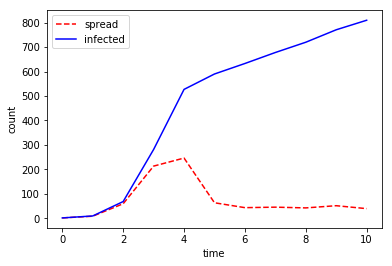

In [600]:
results.showSpreading(tag)

In [601]:
print(nx.info(graph12))

Name: 
Type: Graph
Number of nodes: 476
Number of edges: 1768
Average degree:   7.4286


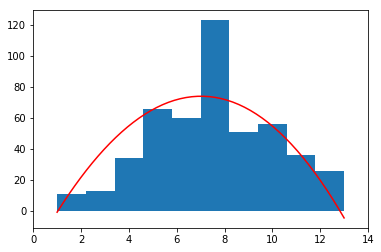

In [602]:
showDegreeDistributionWithFit(graph12)

In [603]:
graphDegreeTopN(graph12)

N    Node     Degree  
---- -------- --------
   1      977       13
   2      992       13
   3      105       12
   4      127       12
   5      657       12
   6      802       12
   7      897       12
   8      902       12
   9      917       12
  10      920       12


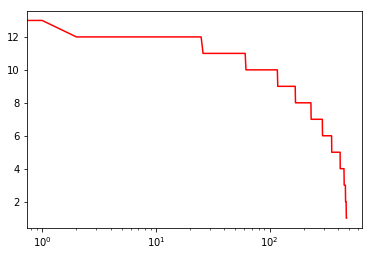

In [604]:
showDegreeDistributionLogScale(graph12)

# Demo

## Spreading only on Barabasi-Albert graph

In [641]:
url = gephiURL(host, port, 1)
tag = "demo-static-ba-spreading-only"

In [642]:
graphA = baGraph()

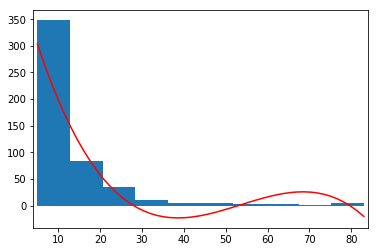

In [643]:
showDegreeDistributionWithFit(graphA)

In [644]:
%%time
gephiGraphNx(graphA)

CPU times: user 10.4 s, sys: 1.51 s, total: 11.9 s
Wall time: 15.3 s


In [645]:
averageDegree(graphA)

13.516

In [646]:
graphDegreeTopN(graphA)

N    Node     Degree  
---- -------- --------
   1        4       83
   2        6       82
   3       13       82
   4        0       78
   5        9       78
   6        7       71
   7        1       64
   8       22       61
   9        2       60
  10        3       57


In [647]:
results.store(tag, simulate(graphA, SpreadingOnly(), Simulation.max_iterations))

time:    1 spread from: 316 -> 281
time:    1 spread from: 316 -> 228
time:    1 spread from: 316 -> 246
time:    1 spread from: 316 -> 117
time:    1 spread from: 316 -> 306
time:    1 spread from: 316 -> 84
time:    1 spread from: 316 -> 88
time:    2 spread from: 84 -> 18
time:    2 spread from: 84 -> 20
time:    2 spread from: 84 -> 1
time:    2 spread from: 84 -> 37
time:    2 spread from: 84 -> 22
time:    2 spread from: 84 -> 0
time:    2 spread from: 84 -> 8
time:    2 spread from: 84 -> 91
time:    2 spread from: 84 -> 92
time:    2 spread from: 84 -> 97
time:    2 spread from: 84 -> 116
time:    2 spread from: 84 -> 136
time:    2 spread from: 84 -> 207
time:    2 spread from: 84 -> 300
time:    2 spread from: 84 -> 330
time:    2 spread from: 84 -> 354
time:    2 spread from: 84 -> 437
time:    2 spread from: 84 -> 467
time:    2 spread from: 88 -> 55
time:    2 spread from: 88 -> 25
time:    2 spread from: 88 -> 28
time:    2 spread from: 88 -> 58
time:    2 spread from: 88

time:    3 spread from: 6 -> 146
time:    3 spread from: 6 -> 198
time:    3 spread from: 6 -> 202
time:    3 spread from: 6 -> 218
time:    3 spread from: 6 -> 225
time:    3 spread from: 6 -> 241
time:    3 spread from: 6 -> 250
time:    3 spread from: 6 -> 262
time:    3 spread from: 6 -> 284
time:    3 spread from: 6 -> 317
time:    3 spread from: 6 -> 320
time:    3 spread from: 6 -> 369
time:    3 spread from: 6 -> 370
time:    3 spread from: 6 -> 384
time:    3 spread from: 6 -> 419
time:    3 spread from: 6 -> 436
time:    3 spread from: 6 -> 438
time:    3 spread from: 6 -> 444
time:    3 spread from: 6 -> 453
time:    3 spread from: 6 -> 470
time:    3 spread from: 6 -> 473
time:    3 spread from: 6 -> 479
time:    3 spread from: 6 -> 496
time:    3 spread from: 7 -> 60
time:    3 spread from: 7 -> 71
time:    3 spread from: 7 -> 89
time:    3 spread from: 7 -> 102
time:    3 spread from: 7 -> 114
time:    3 spread from: 7 -> 122
time:    3 spread from: 7 -> 151
time:    3 sp

In [648]:
results.showResultsTable(tag)

,time,spread_count,spread_total,growth_count,growth_total,destruction_count,destruction_total
0,0,1,1,NaN,NaN,NaN,NaN
1,1,7,8,NaN,NaN,NaN,NaN
2,2,81,89,NaN,NaN,NaN,NaN
3,3,394,483,NaN,NaN,NaN,NaN
4,4,17,500,NaN,NaN,NaN,NaN
5,5,0,500,NaN,NaN,NaN,NaN


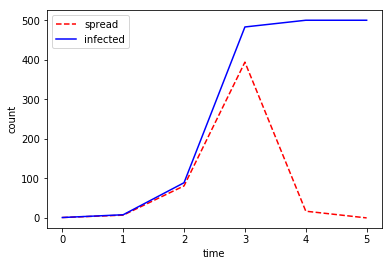

In [649]:
results.showSpreading(tag)

## Spreading with Extremely Invasive on Erdos-Renyi network

In [650]:
url = gephiURL(host, port, 2)
tag = "demo-dynamic-er-additive-with-extremely-invasive-detractive"

In [651]:
graphB = randomGraph()

In [652]:
print(nx.info(graphB))

Name: 
Type: Graph
Number of nodes: 500
Number of edges: 1267
Average degree:   5.0680


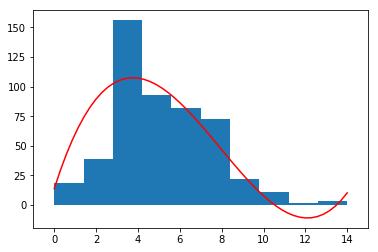

In [653]:
showDegreeDistributionWithFit(graphB)

In [654]:
%%time
gephiGraphNx(graphB)

CPU times: user 4.99 s, sys: 737 ms, total: 5.73 s
Wall time: 7.34 s


In [655]:
graphDegreeTopN(graphB)

N    Node     Degree  
---- -------- --------
   1       46       14
   2      258       13
   3      319       13
   4      392       12
   5      480       12
   6      356       11
   7      382       11
   8       82       10
   9      170       10
  10      231       10


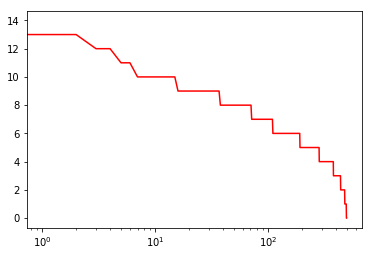

In [656]:
showDegreeDistributionLogScale(graphB)

In [657]:
results.store(tag, simulate(graphB, AddativeWithExtremeInvasiveDetractive(graphB), Simulation.max_iterations))

time:    1 spread from: 276 -> 100
time:    1 spread from: 276 -> 268
time:    2 spread from: 268 -> 34
time:    2 spread from: 268 -> 293
time:    2 spread from: 268 -> 546
time:    3 spread from: 293 -> 74
time:    3 spread from: 293 -> 313
time:    3 spread from: 293 -> 563
time:    3 spread from: 546 -> 451
time:    3 spread from: 546 -> 213
time:    3 spread from: 546 -> 591
time:    3 spread from: 546 -> 618
time:    4 spread from: 74 -> 21
time:    4 spread from: 74 -> 495
time:    4 spread from: 74 -> 621
time:    4 spread from: 74 -> 692
time:    4 spread from: 213 -> 235
time:    4 spread from: 213 -> 632
time:    4 spread from: 268 -> 690
time:    4 spread from: 268 -> 703
time:    4 spread from: 313 -> 53
time:    4 spread from: 451 -> 58
time:    4 spread from: 451 -> 628
time:    4 spread from: 451 -> 662
time:    4 spread from: 563 -> 654
time:    4 spread from: 591 -> 134
time:    4 spread from: 591 -> 388
time:    4 spread from: 591 -> 620
time:    4 spread from: 618 -

time:    8 spread from: 147 -> 169
time:    8 spread from: 147 -> 385
time:    8 spread from: 165 -> 334
time:    8 spread from: 180 -> 417
time:    8 spread from: 180 -> 542
time:    8 spread from: 191 -> 379
time:    8 spread from: 204 -> 905
time:    8 spread from: 213 -> 861
time:    8 spread from: 244 -> 292
time:    8 spread from: 244 -> 432
time:    8 spread from: 270 -> 514
time:    8 spread from: 276 -> 876
time:    8 spread from: 276 -> 893
time:    8 spread from: 277 -> 475
time:    8 spread from: 277 -> 871
time:    8 spread from: 313 -> 895
time:    8 spread from: 315 -> 741
time:    8 spread from: 315 -> 759
time:    8 spread from: 316 -> 892
time:    8 spread from: 316 -> 897
time:    8 spread from: 317 -> 533
time:    8 spread from: 335 -> 525
time:    8 spread from: 362 -> 250
time:    8 spread from: 388 -> 902
time:    8 spread from: 394 -> 815
time:    8 spread from: 415 -> 888
time:    8 spread from: 426 -> 552
time:    8 spread from: 426 -> 595
time:    8 spread fr

time:   10 spread from: 169 -> 1006
time:   10 spread from: 175 -> 996
time:   10 spread from: 222 -> 254
time:   10 spread from: 243 -> 989
time:   10 spread from: 253 -> 985
time:   10 spread from: 302 -> 979
time:   10 spread from: 302 -> 990
time:   10 spread from: 313 -> 970
time:   10 spread from: 313 -> 1009
time:   10 spread from: 316 -> 988
time:   10 spread from: 331 -> 968
time:   10 spread from: 334 -> 983
time:   10 spread from: 358 -> 999
time:   10 spread from: 362 -> 982
time:   10 spread from: 373 -> 967
time:   10 spread from: 377 -> 974
time:   10 spread from: 379 -> 959
time:   10 spread from: 385 -> 975
time:   10 spread from: 393 -> 509
time:   10 spread from: 404 -> 584
time:   10 spread from: 438 -> 1000
time:   10 spread from: 462 -> 963
time:   10 spread from: 471 -> 991
time:   10 spread from: 532 -> 143
time:   10 spread from: 552 -> 962
time:   10 spread from: 566 -> 1007
time:   10 spread from: 569 -> 977
time:   10 spread from: 579 -> 966
time:   10 sprea

In [658]:
results.showResultsTable(tag)

,time,spread_count,spread_total,growth_count,growth_total,destruction_count,destruction_total
0,0,1,1,0,0,0,0
1,1,2,3,50,50,55,55
2,2,3,6,50,100,54,109
3,3,7,13,50,150,54,163
4,4,18,31,50,200,54,217
5,5,34,65,50,250,53,270
6,6,64,129,50,300,53,323
7,7,100,229,50,350,53,376
8,8,128,357,50,400,53,429
9,9,124,481,50,450,53,482


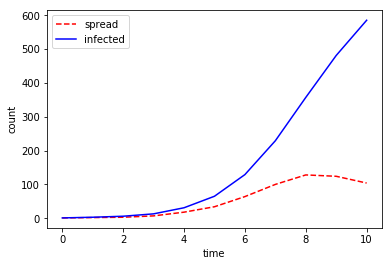

In [659]:
results.showSpreading(tag)

In [660]:
print(nx.info(graphB))

Name: 
Type: Graph
Number of nodes: 476
Number of edges: 593
Average degree:   2.4916


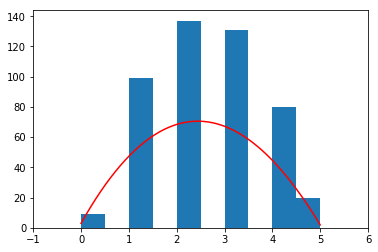

In [661]:
showDegreeDistributionWithFit(graphB)

In [662]:
graphDegreeTopN(graphB)

N    Node     Degree  
---- -------- --------
   1      865        5
   2      918        5
   3      920        5
   4      922        5
   5      924        5
   6      935        5
   7      946        5
   8      950        5
   9      952        5
  10      971        5


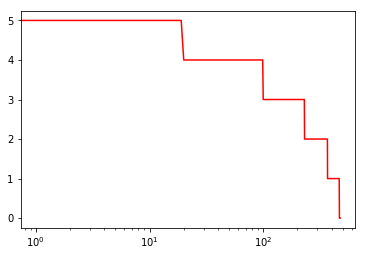

In [663]:
showDegreeDistributionLogScale(graphB)

# Results

# Conclusion

# What's Next?

# References